In [1]:
# === R-0) Variant setup: run this first (keeps outputs separate) ===
# Comments in English.

import os, random, numpy as np, torch

# Choose a variant name to separate outputs
VARIANT = "rig"           # e.g., "rig", "rig_ind", "ablation_trust_off"
ECO = True                # energy-saver
USE_GPU_FOR_GNN = True    # GPU only for GNN if ECO=False
SEED = 42

# Mount Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print("Drive mount warning:", e)

# Base project folder (same as your original)
BASE_ROOT = "/content/drive/MyDrive/WSN_Fusion_project"

# Shared RAW; variant-specific PROC/GRAPHS/ART
DATA_ROOT = BASE_ROOT
RAW   = f"{DATA_ROOT}/data/raw"                 # shared
PROC  = f"{DATA_ROOT}/data/processed_{VARIANT}" # new
GRAPHS= f"{DATA_ROOT}/graphs_{VARIANT}"         # new
ART   = f"{DATA_ROOT}/artifacts_{VARIANT}"      # new

for p in (PROC, GRAPHS, ART):
    os.makedirs(p, exist_ok=True)

# Repro and device
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if (torch.cuda.is_available() and USE_GPU_FOR_GNN and not ECO) else 'cpu')

print("VARIANT:", VARIANT)
print("RAW:", RAW)
print("PROC:", PROC)
print("GRAPHS:", GRAPHS)
print("ART:", ART)
print("ECO:", ECO, "| device:", device)


Mounted at /content/drive
VARIANT: rig
RAW: /content/drive/MyDrive/WSN_Fusion_project/data/raw
PROC: /content/drive/MyDrive/WSN_Fusion_project/data/processed_rig
GRAPHS: /content/drive/MyDrive/WSN_Fusion_project/graphs_rig
ART: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig
ECO: True | device: cpu


In [2]:
# Install PyTorch Geometric (auto-detect, CPU-safe fallback) ===
# Comments in English.

import sys, subprocess, pkgutil, re

def pipU(*args):
    cmd = [sys.executable, "-m", "pip", "install", "-U", "-q"] + list(args)
    print("[pip]", " ".join(cmd[2:]))
    subprocess.check_call(cmd)

def pip_uninstall(*pkgs):
    if not pkgs: return
    cmd = [sys.executable, "-m", "pip", "uninstall", "-y"] + list(pkgs)
    print("[pip]", " ".join(cmd[2:]))
    subprocess.call(cmd)

# Try importing torch_geometric first
try:
    import torch, torch_geometric
    from torch_geometric.data import Data
    print("✅ torch:", torch.__version__, "| ✅ torch_geometric:", torch_geometric.__version__)
except Exception:
    import torch
    torch_ver = torch.__version__  # e.g., '2.6.0+cu121' or '2.4.0+cpu'
    print("Torch detected:", torch_ver)

    # Build the PyG wheel index URL matching current Torch tag if possible
    tag = torch_ver.split('+')
    if len(tag) == 2:
        base_tag = tag[0] + "+" + tag[1]
    else:
        # No CUDA tag -> assume cpu
        base_tag = tag[0] + "+cpu"
    pyg_index = f"https://data.pyg.org/whl/torch-{base_tag}.html"
    print("Attempting native install for Torch tag:", base_tag)

    try:
        # Primary path: keep current torch, install PyG + ops matching current tag
        pipU("torch_geometric")
        pipU("pyg_lib", "torch_scatter", "torch_sparse", "torch_cluster", "torch_spline_conv", "-f", pyg_index)

    except subprocess.CalledProcessError as e:
        print("\nPrimary install failed. Falling back to a CPU-safe, known-good stack (Torch 2.4.0+cpu).")
        # Fallback path: clean out possibly conflicting packages
        pip_uninstall("torch_geometric", "pyg_lib", "torch_scatter", "torch_sparse", "torch_cluster", "torch_spline_conv")

        # Install Torch CPU (2.4.0) trio
        pipU("torch==2.4.0+cpu", "torchvision==0.19.0+cpu", "torchaudio==2.4.0+cpu",
             "--index-url", "https://download.pytorch.org/whl/cpu")

        # Install PyG and CPU wheels for 2.4.0
        pipU("torch_geometric")
        pipU("pyg_lib", "torch_scatter", "torch_sparse", "torch_cluster", "torch_spline_conv",
             "-f", "https://data.pyg.org/whl/torch-2.4.0+cpu.html")

    # Final import check
    import torch_geometric
    from torch_geometric.data import Data
    import torch
    print("✅ Ready — torch:", torch.__version__, "| torch_geometric:", torch_geometric.__version__)


Torch detected: 2.6.0+cu124
Attempting native install for Torch tag: 2.6.0+cu124
[pip] pip install -U -q torch_geometric
[pip] pip install -U -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
✅ Ready — torch: 2.6.0+cu124 | torch_geometric: 2.6.1


In [3]:
# R-2 — Robust loaders (self-contained): defines load_* and returns df_cic, df_nsl, df_wsn, df_ton, dfs
from pathlib import Path
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm

assert 'RAW' in globals(), "RAW must be defined in R-0"
RAW = Path(RAW)  # e.g. /content/drive/MyDrive/WSN_Fusion_project/data/raw

# ---------- Helpers ----------

def read_csv_compat(fp):
    """
    CSV/TXT reader compatible across pandas versions and common delimiters.
    Tries comma, then whitespace, then semicolon. Falls back to latin-1 if needed.
    """
    fp = str(fp)
    for enc in ("utf-8", "latin-1"):
        # Try comma
        try:
            df = pd.read_csv(fp, sep=",", low_memory=False, encoding=enc, on_bad_lines="skip")
            if df.shape[1] > 1:
                return df
        except TypeError:
            # older pandas: on_bad_lines -> error_bad_lines/warn_bad_lines
            try:
                df = pd.read_csv(fp, sep=",", low_memory=False, encoding=enc,
                                 error_bad_lines=False, warn_bad_lines=False, engine="python")
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass
        except Exception:
            pass
        # Try whitespace
        try:
            df = pd.read_csv(fp, sep=r"\s+", low_memory=False, encoding=enc, engine="python")
            if df.shape[1] > 1:
                return df
        except Exception:
            pass
        # Try semicolon
        try:
            df = pd.read_csv(fp, sep=";", low_memory=False, encoding=enc, on_bad_lines="skip")
            if df.shape[1] > 1:
                return df
        except TypeError:
            try:
                df = pd.read_csv(fp, sep=";", low_memory=False, encoding=enc,
                                 error_bad_lines=False, warn_bad_lines=False, engine="python")
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass
        except Exception:
            pass
    # Last resort: single-column as-is (will be dropped later if useless)
    return pd.read_csv(fp, low_memory=False, encoding_errors="ignore")

def enforce_unique_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean headers (strip, collapse spaces, drop Unnamed) and make column names unique.
    """
    df = df.copy()
    cols = (pd.Index(df.columns)
            .map(lambda c: str(c).replace('\ufeff',''))
            .map(lambda c: c.strip())
            .map(lambda c: re.sub(r"\s+"," ", c)))
    df.columns = cols
    df = df.loc[:, ~df.columns.str.match(r"^Unnamed", na=False)]
    if df.columns.has_duplicates:
        seen = {}
        new_cols = []
        for c in df.columns:
            k = seen.get(c, 0)
            new_cols.append(c if k == 0 else f"{c}__dup{k}")
            seen[c] = k + 1
        df.columns = pd.Index(new_cols)
    if df.index.duplicated().any():
        df = df.reset_index(drop=True)
    return df

def maybe_infer_label_last_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    If no label-like column is present, but the last column looks like a categorical label
    (e.g., contains 'normal', 'neptune', etc.), rename it to 'Label' for downstream mapping.
    """
    label_like = [c for c in df.columns if re.search(r"^(label|class|attack|category|outcome)$", str(c), flags=re.I)]
    if label_like:
        return df
    last = df.columns[-1]
    s = df[last]
    # Heuristic: non-numeric or small cardinality suggests a label column
    cond = (not pd.api.types.is_numeric_dtype(s)) or (s.nunique(dropna=True) <= 100)
    tokens = {"normal","benign","neptune","dos","probe","r2l","u2r","anomaly","attack","malicious"}
    looks_like = cond or (set(s.astype(str).str.lower().str.replace(r"\s+","",regex=True)).intersection(tokens))
    if looks_like:
        df = df.rename(columns={last: "Label"})
    return df

# ---------- Dataset-specific loaders ----------

def load_cicids2017(root: Path) -> pd.DataFrame:
    """
    Find CICIDS2017 CSVs under common folders and concatenate.
    """
    candidates = [root/"CICIDS2017", root/"cicids2017", root/"CICIDS", root/"cicids"]
    files = []
    for base in candidates:
        if base.exists():
            files = sorted(base.rglob("*.csv"))
            if files: break
    if not files:
        # global fallback
        files = [p for p in root.rglob("*.csv") if "cicids" in str(p).lower()]
    assert files, "CICIDS2017 CSVs not found under RAW"
    dfs = []
    for fp in tqdm(files, desc="CICIDS2017 CSVs"):
        df = read_csv_compat(fp)
        df = enforce_unique_columns(df)
        df = maybe_infer_label_last_column(df)
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"Loaded CICIDS2017: {out.shape}")
    return out

def load_nslkdd(root: Path) -> pd.DataFrame:
    """
    Load NSL-KDD from CSV/TXT; infer delimiter; try to name last column 'Label' if needed.
    """
    candidates = [root/"NSL-KDD", root/"NSL_KDD", root/"nsl-kdd", root/"nslkdd"]
    files = []
    for base in candidates:
        if base.exists():
            files = sorted(list(base.rglob("*.txt")) + list(base.rglob("*.csv")))
            if files: break
    if not files:
        files = [p for p in root.rglob("*.*") if ("nsl" in str(p).lower() and p.suffix.lower() in (".txt",".csv"))]
    assert files, "NSL-KDD files not found under RAW"
    dfs = []
    for fp in tqdm(files, desc="NSL-KDD TXT"):
        if fp.suffix.lower() == ".txt":
            # try whitespace first
            try:
                df = pd.read_csv(fp, sep=r"\s+", header=None, engine="python", low_memory=False)
            except Exception:
                df = read_csv_compat(fp)
        else:
            df = read_csv_compat(fp)
        df = enforce_unique_columns(df)
        df = maybe_infer_label_last_column(df)
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"Loaded NSL-KDD: {out.shape}")
    return out

def load_wsnds(root: Path) -> pd.DataFrame:
    """
    Load WSN-DS CSVs from typical folders.
    """
    candidates = [root/"WSN-DS", root/"WSN_DS", root/"wsn-ds", root/"wsnds", root/"WSNDS"]
    files = []
    for base in candidates:
        if base.exists():
            files = sorted(base.rglob("*.csv"))
            if files: break
    if not files:
        files = [p for p in root.rglob("*.csv") if "wsn" in str(p).lower()]
    assert files, "WSN-DS CSVs not found under RAW"
    dfs = []
    for fp in tqdm(files, desc="WSN-DS CSV"):
        df = read_csv_compat(fp)
        df = enforce_unique_columns(df)
        df = maybe_infer_label_last_column(df)
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"Loaded WSN-DS: {out.shape}")
    return out

def load_toniot_telemetry(root: Path) -> pd.DataFrame:
    """
    Load ToN-IoT telemetry (your layout: RAW/toniot/IoT_filtered_*/*.csv).
    Falls back to common ToN-IoT trees.
    """
    base_candidates = [
        root/"toniot",                         # your case
        root/"ToN-IoT"/"telemetry",
        root/"ToN-IoT", root/"ToN_IoT", root/"TON_IoT"
    ]
    files = []
    for base in base_candidates:
        if base.exists():
            pref = sorted(base.rglob("IoT_*.csv"))
            if pref:
                files = pref; break
            anycsv = sorted(base.rglob("*.csv"))
            if anycsv:
                files = anycsv; break
    if not files:
        # global fallback
        files = [p for p in root.rglob("*.csv") if ("iot_" in p.name.lower() or "toni" in str(p).lower())]
    assert files, "ToN-IoT telemetry CSVs not found under RAW"
    dfs = []
    for fp in tqdm(files, desc="ToN-IoT telemetry CSVs"):
        df = read_csv_compat(fp)
        df = enforce_unique_columns(df)
        df = maybe_infer_label_last_column(df)
        dfs.append(df)
    out = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"Loaded ToN-IoT: {out.shape}")
    return out

# ---------- Execute loads ----------
df_cic = load_cicids2017(RAW)
df_nsl = load_nslkdd(RAW)
df_wsn = load_wsnds(RAW)
df_ton = load_toniot_telemetry(RAW)

dfs = [df_cic, df_nsl, df_wsn, df_ton]
print("[R-2] Loaded 4 datasets -> dfs ready.")


CICIDS2017 CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded CICIDS2017: (2830743, 79)


NSL-KDD TXT:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded NSL-KDD: (185555, 69)


WSN-DS CSV:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded WSN-DS: (374661, 19)


ToN-IoT telemetry CSVs:   0%|          | 0/84 [00:00<?, ?it/s]

Loaded ToN-IoT: (4081235, 23)
[R-2] Loaded 4 datasets -> dfs ready.


In [4]:
# R-2b — Bridge: ensure each df has a binary 'y' column (only if missing)
# (Keeps your R-3 API intact: it expects 'y' already present.)
import re
import numpy as np
import pandas as pd

def _detect_label_col(cols: pd.Index):
    pats = [r"^label$", r"^class$", r"^attack$", r"^category$", r"^outcome$"]
    for pat in pats:
        hits = [c for c in cols if re.match(pat, str(c), flags=re.I)]
        if hits: return hits[0]
    if "Label" in cols: return "Label"
    if "label" in cols: return "label"
    return None

_BENIGN = {"benign","normal","normaltraffic","nomal","no_attack","legit","0"}
def _to_y(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        return (series.astype(float) != 0).astype(int)
    s = series.astype(str).str.strip().str.lower().str.replace(r"\s+","", regex=True)
    y = np.where(s.isin(_BENIGN), 0, 1)
    y = np.where(s=="1", 1, y)
    return pd.Series(y, index=series.index, dtype=int)

def ensure_y(df: pd.DataFrame, name: str) -> pd.DataFrame:
    if 'y' in df.columns:
        return df
    lbl = _detect_label_col(df.columns)
    if lbl is None:
        raise KeyError(f"[{name}] no label-like column found; please add 'y' in loader.")
    out = df.copy()
    out['y'] = _to_y(out[lbl])
    return out

df_cic = ensure_y(df_cic, "CICIDS2017")
df_nsl = ensure_y(df_nsl, "NSL-KDD")
df_wsn = ensure_y(df_wsn, "WSN-DS")
df_ton = ensure_y(df_ton, "ToN-IoT")

dfs = [df_cic, df_nsl, df_wsn, df_ton]
print("[R-2b] Ensured 'y' exists in all dfs.")


[R-2b] Ensured 'y' exists in all dfs.


In [ ]:
# R-3 — unify_and_split_v3 (memory-optimized) — HOTFIX v3
# - Non-capturing boundary groups to avoid warnings
# - Robust boolean mask via pd.Series(...).str.contains(...) (no .values)

import os, json, gc, joblib, re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

try:
    from imblearn.over_sampling import RandomOverSampler
    _HAS_IMB = True
except Exception:
    _HAS_IMB = False

CAP_PER_DATASET    = 150_000 if 'ECO' in globals() and ECO else 600_000
CORR_SAMPLE        = 200_000 if 'ECO' in globals() and ECO else 500_000
TARGET_POS_RATIO   = 0.50    if 'ECO' in globals() and ECO else 0.90
MAX_TRAIN_AFTER_OS = 800_000 if 'ECO' in globals() and ECO else 1_500_000

# Non-capturing groups everywhere
LABEL_LIKE_PAT = r'(?:^|_)(?:label|attack|class|target|anomal(?:y)?|malicious)(?:_|$)'

def _make_unique(names):
    seen = {}; out=[]
    for n in names:
        if n not in seen: seen[n]=0; out.append(n)
        else: seen[n]+=1; out.append(f"{n}__dup{seen[n]}")
    return out

def _sanitize_one(df: pd.DataFrame) -> pd.DataFrame:
    """Keep numeric features + 'y'; drop label-like leak columns, Unnamed; cast float32; fix non-finite."""
    assert 'y' in df.columns, "Expected binary target 'y' before R-3 (see R-2b)."
    # Drop Unnamed / technical
    drop_meta = [c for c in df.columns if str(c).lower().startswith('unnamed')]
    df = df.drop(columns=drop_meta, errors='ignore')
    # Drop any label-like columns except 'y' (no warnings, no .values)
    mask = pd.Series(df.columns, dtype=str).str.contains(LABEL_LIKE_PAT, case=False, regex=True)
    lab_cols = [c for c, m in zip(df.columns, mask) if m and c != 'y']
    df = df.drop(columns=lab_cols, errors='ignore')
    # Keep numerics only + y
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    keep = list(dict.fromkeys(num + ['y']))
    df = df[keep]
    # Dtypes & non-finite
    for c in df.columns:
        if c != 'y':
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    feat_cols = [c for c in df.columns if c != 'y']
    df[feat_cols] = df[feat_cols].astype(np.float32)
    df['y'] = df['y'].astype(np.int8)
    df.columns = _make_unique(df.columns)
    return df

def _stratified_cap(df: pd.DataFrame, cap: int, seed: int = 42) -> pd.DataFrame:
    n = len(df)
    if cap is None or n <= cap: return df
    y = df['y'].to_numpy()
    sss = StratifiedShuffleSplit(n_splits=1, train_size=cap, random_state=seed)
    idx = next(sss.split(np.zeros_like(y), y))[0]
    return df.iloc[idx].reset_index(drop=True)

def _union_columns(dfs_sanitized):
    seen = set(); out=[]
    for d in dfs_sanitized:
        for c in d.columns:
            if c == 'y': continue
            if c not in seen:
                seen.add(c); out.append(c)
    return out

def sklearn_stratified_sample(X_df, y, n_keep, seed=42):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_keep, random_state=seed)
    idx = next(sss.split(np.zeros_like(y), y))[0]
    return X_df.iloc[idx], y.iloc[idx]

def _drop_leaky_by_corr(X_tr_df: pd.DataFrame, y_tr: pd.Series, max_rows: int):
    """Compute |corr(x,y)| on a sample of train; drop features > 0.995."""
    if len(X_tr_df) > max_rows:
        Xs, ys = sklearn_stratified_sample(X_tr_df, y_tr, max_rows, SEED if 'SEED' in globals() else 42)
    else:
        Xs, ys = X_tr_df, y_tr
    xr = Xs.to_numpy(dtype=np.float32, copy=False)
    yr = ys.to_numpy(dtype=np.float32, copy=False)
    corrs = []
    yr_center = yr - yr.mean()
    denom_y = (np.sqrt((yr_center**2).sum()) + 1e-12)
    for j in range(xr.shape[1]):
        col = xr[:, j]
        c = col - col.mean()
        denom_x = (np.sqrt((c**2).sum()) + 1e-12)
        r = float(np.dot(c, yr_center) / (denom_x * denom_y))
        corrs.append(abs(r))
    drop_idx = np.where(np.array(corrs, dtype=np.float32) > 0.995)[0]
    return [X_tr_df.columns[i] for i in drop_idx]

def unify_and_split(dfs, test_size=0.2, val_size=0.1, random_state=42, balance=True):
    # 1) sanitize each df
    san = [_sanitize_one(d) for d in dfs]
    # 2) cap per dataset (stratified)
    capped = [_stratified_cap(sd, CAP_PER_DATASET, seed=random_state) for sd in san]
    del san; gc.collect()
    # 3) align to union(feature) columns and concat
    union_cols = _union_columns(capped)
    aligned = []
    for cd in capped:
        Xi = cd.drop(columns=['y']).reindex(columns=union_cols, fill_value=0.0)
        yi = cd['y']
        aligned.append(pd.concat([Xi, yi], axis=1))
    del capped; gc.collect()
    df = pd.concat(aligned, ignore_index=True); del aligned; gc.collect()

    # 4) split BEFORE scaling/oversampling
    Xdf_full = df.drop(columns=['y']); y_full = df['y'].astype(int); del df; gc.collect()
    X_tr, X_te, y_tr, y_te = train_test_split(Xdf_full, y_full, test_size=test_size, stratify=y_full, random_state=random_state)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=val_size, stratify=y_tr, random_state=random_state)

    # 4b) drop highly correlated with y on TRAIN sample
    leak_cols = _drop_leaky_by_corr(X_tr, y_tr, max_rows=CORR_SAMPLE)
    if leak_cols:
        print(f"• Dropping {len(leak_cols)} high-corr-to-y features on train (>|0.995|).")
        for dset in (X_tr, X_va, X_te): dset.drop(columns=leak_cols, inplace=True, errors='ignore')

    # 5) scale using TRAIN only
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr.astype(np.float32).values)
    X_va_s = scaler.transform(X_va.astype(np.float32).values)
    X_te_s = scaler.transform(X_te.astype(np.float32).values)

    # 6) controlled oversampling (TRAIN only)
    if balance and _HAS_IMB:
        classes, counts = np.unique(y_tr.values, return_counts=True)
        if len(classes) == 2:
            n_maj, n_min = int(counts.max()), int(counts.min())
            min_label = int(classes[np.argmin(counts)])
            desired_min = int(min(n_maj * TARGET_POS_RATIO, MAX_TRAIN_AFTER_OS - n_maj))
            if desired_min > n_min and (n_maj + desired_min) <= MAX_TRAIN_AFTER_OS:
                print(f"• Oversampling TRAIN minority from {n_min} → {desired_min} (ratio≈{TARGET_POS_RATIO:.2f})")
                ros = RandomOverSampler(sampling_strategy={min_label: desired_min}, random_state=random_state)
                X_tr_s, y_tr = ros.fit_resample(X_tr_s, y_tr)
            else:
                print("• Skipping oversampling: already balanced or cap would be exceeded.")
        else:
            print("• Skipping oversampling: single-class train detected.")
    elif balance and not _HAS_IMB:
        print("• imbalanced-learn not available; skipping oversampling.")

    # 7) save to PROC
    os.makedirs(PROC, exist_ok=True)
    X_tr_s = np.asarray(X_tr_s, dtype=np.float32); X_va_s = np.asarray(X_va_s, dtype=np.float32); X_te_s = np.asarray(X_te_s, dtype=np.float32)
    y_tr = pd.Series(np.asarray(y_tr, dtype=np.int8), name='y')
    y_va = pd.Series(np.asarray(y_va, dtype=np.int8), name='y')
    y_te = pd.Series(np.asarray(y_te, dtype=np.int8), name='y')
    pd.concat([pd.DataFrame(X_tr_s), y_tr.reset_index(drop=True)], axis=1).to_parquet(f"{PROC}/train.parquet", index=False)
    pd.concat([pd.DataFrame(X_va_s), y_va.reset_index(drop=True)], axis=1).to_parquet(f"{PROC}/val.parquet", index=False)
    pd.concat([pd.DataFrame(X_te_s), y_te.reset_index(drop=True)], axis=1).to_parquet(f"{PROC}/test.parquet", index=False)
    joblib.dump(scaler, f"{PROC}/scaler.joblib")
    n_features = int(X_tr_s.shape[1])
    with open(f"{PROC}/meta.json","w") as f: json.dump({'n_features': n_features}, f, indent=2)
    # free big refs
    del Xdf_full, X_tr, X_va, X_te, X_tr_s, X_va_s, X_te_s; gc.collect()
    print(f"✓ Saved splits to {PROC} | n_features: {n_features}")
    return True

# ---- Run preprocessing ----
unify_and_split(dfs, test_size=0.2, val_size=0.1,
                random_state=SEED if 'SEED' in globals() else 42,
                balance=True)


• Skipping oversampling: already balanced or cap would be exceeded.
✓ Saved splits to /content/drive/MyDrive/WSN_Fusion_project/data/processed_rig | n_features: 167


True

In [ ]:
# === R-4) Build graph with trust (MCDM) + dual mode: TRANSDUCTIVE or INDUCTIVE ===


import os, time, numpy as np, pandas as pd, torch
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data

MODE = "TRANSDUCTIVE"   # choose: "TRANSDUCTIVE" or "INDUCTIVE"

# Load processed splits from PROC (variant)
train = pd.read_parquet(f"{PROC}/train.parquet")
val   = pd.read_parquet(f"{PROC}/val.parquet")
test  = pd.read_parquet(f"{PROC}/test.parquet")

X_train, y_train = train.drop(columns=['y']).to_numpy(np.float32), train['y'].to_numpy(np.int64)
X_val,   y_val   = val.drop(columns=['y']).to_numpy(np.float32),   val['y'].to_numpy(np.int64)
X_test,  y_test  = test.drop(columns=['y']).to_numpy(np.float32),  test['y'].to_numpy(np.int64)

X_all = np.concatenate([X_train, X_val, X_test], axis=0)
y_all = np.concatenate([y_train, y_val, y_test], axis=0)
n_tr, n_va, n_te = len(y_train), len(y_val), len(y_test)
N = len(y_all)
idx_train = np.arange(0, n_tr)
idx_val   = np.arange(n_tr, n_tr+n_va)
idx_test  = np.arange(n_tr+n_va, N)

# ECO cap (optional)
NODE_CAP = 200_000 if ECO else 400_000
if N > NODE_CAP:
    print(f"[ECO] Capping nodes from {N} -> {NODE_CAP}")
    from sklearn.model_selection import StratifiedShuffleSplit
    def sample_idxs(idxs, y, keep):
        if len(idxs) <= keep: return idxs
        ysub = y[idxs]
        sss = StratifiedShuffleSplit(n_splits=1, train_size=keep, random_state=SEED)
        take = next(sss.split(np.zeros_like(ysub), ysub))[0]
        return idxs[take]
    cap_tr = int(NODE_CAP * (n_tr/N)); cap_va = int(NODE_CAP * (n_va/N)); cap_te = NODE_CAP - cap_tr - cap_va
    idx_train = sample_idxs(idx_train, y_all, cap_tr)
    idx_val   = sample_idxs(idx_val,   y_all, cap_va)
    idx_test  = sample_idxs(idx_test,  y_all, cap_te)
    keep = np.concatenate([idx_train, idx_val, idx_test])
    X_all, y_all = X_all[keep], y_all[keep]
    n_tr, n_va, n_te = len(idx_train), len(idx_val), len(idx_test)
    N = len(y_all)
    idx_train = np.arange(0, n_tr); idx_val = np.arange(n_tr, n_tr+n_va); idx_test = np.arange(n_tr+n_va, N)

# --- Trust from train neighbors (kNN/cosine) ---
def minmax_clip01(arr, p_lo=1, p_hi=99):
    lo, hi = np.nanpercentile(arr, p_lo), np.nanpercentile(arr, p_hi)
    arr = np.clip(arr, lo, hi)
    if hi > lo: arr = (arr - lo) / (hi - lo)
    else: arr[:] = 0.0
    return np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=0.0).astype(np.float32)

def chunked_kneighbors(model, X, k, batch=8192, desc="kNN"):
    n = len(X); D = np.empty((n,k), np.float32); I = np.empty((n,k), np.int64)
    for s in tqdm(range(0, n, batch), desc=desc, unit="batch"):
        e = min(s+batch, n); d,i = model.kneighbors(X[s:e], n_neighbors=k, return_distance=True)
        D[s:e] = d.astype(np.float32); I[s:e] = i.astype(np.int64)
    return D, I

K_TRUST = 8 if ECO else 16
nn_trust = NearestNeighbors(n_neighbors=K_TRUST+1, metric="cosine", n_jobs=-1).fit(X_all[idx_train])

# Train queries (drop self)
d_tr, i_tr = chunked_kneighbors(nn_trust, X_all[idx_train], K_TRUST+1, desc="Trust kNN (train)")
d_tr = d_tr[:,1:]; i_tr = i_tr[:,1:]; i_tr_abs = idx_train[i_tr]
y_nei_tr = y_all[i_tr_abs]
R_tr = (y_nei_tr==0).mean(axis=1).astype(np.float32)
C_tr = 1.0 - minmax_clip01(d_tr.mean(axis=1))
H_tr = 1.0 - minmax_clip01(np.median(d_tr, axis=1))

# Val/Test against train
d_va, i_va = chunked_kneighbors(nn_trust, X_all[idx_val],  K_TRUST, desc="Trust kNN (val)")
d_te, i_te = chunked_kneighbors(nn_trust, X_all[idx_test], K_TRUST, desc="Trust kNN (test)")
R_va = (y_all[idx_train][i_va]==0).mean(axis=1).astype(np.float32)
R_te = (y_all[idx_train][i_te]==0).mean(axis=1).astype(np.float32)
C_va = 1.0 - minmax_clip01(d_va.mean(axis=1)); H_va = 1.0 - minmax_clip01(np.median(d_va, axis=1))
C_te = 1.0 - minmax_clip01(d_te.mean(axis=1)); H_te = 1.0 - minmax_clip01(np.median(d_te, axis=1))

R = np.empty(N, np.float32); C = np.empty(N, np.float32); H = np.empty(N, np.float32)
R[idx_train], C[idx_train], H[idx_train] = R_tr, C_tr, H_tr
R[idx_val],   C[idx_val],   H[idx_val]   = R_va, C_va, H_va
R[idx_test],  C[idx_test],  H[idx_test]  = R_te, C_te, H_te

W_R, W_C, W_H = 0.4, 0.3, 0.3
T = (W_R*R + W_C*C + W_H*H).astype(np.float32)
X_aug = np.concatenate([X_all, R[:,None], C[:,None], H[:,None], T[:,None]], axis=1).astype(np.float32)

# --- Build edges ---
K_GRAPH = 8 if ECO else 16

if MODE.upper() == "TRANSDUCTIVE":
    # kNN on ALL nodes
    nn_graph = NearestNeighbors(n_neighbors=K_GRAPH, metric="cosine", n_jobs=-1).fit(X_aug)
    edges_src, edges_dst, edges_w = [], [], []
    for s in tqdm(range(0, N, 4096), desc="Graph kNN (transductive)", unit="batch"):
        e = min(s+4096, N); d,ind = nn_graph.kneighbors(X_aug[s:e], n_neighbors=K_GRAPH, return_distance=True)
        src = np.repeat(np.arange(s,e), K_GRAPH); dst = ind.reshape(-1); wts = (1.0 - d.reshape(-1)).astype(np.float32)
        m = src != dst
        edges_src.append(src[m]); edges_dst.append(dst[m]); edges_w.append(wts[m])
    src = np.concatenate(edges_src); dst = np.concatenate(edges_dst); edge_w = np.concatenate(edges_w).astype(np.float32)

else:  # INDUCTIVE: train↔train, and val/test -> train only
    edges_src, edges_dst, edges_w = [], [], []
    # Train: neighbors within train (K+1, drop self)
    nn_tr = NearestNeighbors(n_neighbors=K_GRAPH+1, metric="cosine", n_jobs=-1).fit(X_aug[idx_train])
    d, ind = nn_tr.kneighbors(X_aug[idx_train], return_distance=True)
    src = np.repeat(idx_train, K_GRAPH); dst = idx_train[ind[:,1:]].reshape(-1)
    wts = (1.0 - d[:,1:].reshape(-1)).astype(np.float32)
    m = src != dst
    edges_src.append(src[m]); edges_dst.append(dst[m]); edges_w.append(wts[m])

    # Val/Test: to train only
    nn_anchor = NearestNeighbors(n_neighbors=K_GRAPH, metric="cosine", n_jobs=-1).fit(X_aug[idx_train])
    for block, name in [(idx_val,"val"), (idx_test,"test")]:
        d, ind = nn_anchor.kneighbors(X_aug[block], n_neighbors=K_GRAPH, return_distance=True)
        src = np.repeat(block, K_GRAPH); dst = idx_train[ind].reshape(-1)
        wts = (1.0 - d.reshape(-1)).astype(np.float32)
        edges_src.append(src); edges_dst.append(dst); edges_w.append(wts)

    src = np.concatenate(edges_src); dst = np.concatenate(edges_dst); edge_w = np.concatenate(edges_w).astype(np.float32)

# Build PyG Data
m = src != dst
edge_index = torch.from_numpy(np.vstack([src[m], dst[m]]).astype(np.int64))
edge_weight = torch.from_numpy(edge_w[m])
x = torch.from_numpy(X_aug); y = torch.from_numpy(y_all)
data = Data(x=x, y=y, edge_index=edge_index)
data.train_mask = torch.zeros(N, dtype=torch.bool); data.train_mask[idx_train] = True
data.val_mask   = torch.zeros(N, dtype=torch.bool); data.val_mask[idx_val]   = True
data.test_mask  = torch.zeros(N, dtype=torch.bool); data.test_mask[idx_test] = True
data.edge_weight = edge_weight

os.makedirs(GRAPHS, exist_ok=True)
GRAPH_FILE = f"{GRAPHS}/graph_{MODE.lower()}.pt"
torch.save(data, GRAPH_FILE)
print("Saved:", GRAPH_FILE, "| nodes:", N, "| edges:", data.edge_index.size(1))


[ECO] Capping nodes from 600000 -> 200000


Graph kNN (transductive): 100%|██████████| 49/49 [09:33<00:00, 11.70s/batch]


Saved: /content/drive/MyDrive/WSN_Fusion_project/graphs_rig/graph_transductive.pt | nodes: 200000 | edges: 1434087


In [ ]:
# R-5 — Train GATv2 (edge_dim=1) and save best to ART/gatv2_best.pt

import os, json, numpy as np, torch
from torch_geometric.nn import GATv2Conv
import torch.nn as nn, torch.nn.functional as F

GRAPH_FILE = sorted([p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")])[-1]
data = torch.load(f"{GRAPHS}/{GRAPH_FILE}", weights_only=False)
edge_attr = data.edge_weight.view(-1,1).to(torch.float32)

class GATv2Net(nn.Module):
    """Two-layer GATv2 with edge_dim=1, 2-class logits (for CrossEntropyLoss)."""
    def __init__(self, in_dim, hidden=32, heads=2, dropout=0.3, n_classes=2):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout, edge_dim=1)
        self.conv2 = GATv2Conv(hidden*heads, n_classes, heads=1, concat=False, dropout=dropout, edge_dim=1)
        self.dropout = dropout
    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv1(x, edge_index, edge_attr=edge_attr); x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index, edge_attr=edge_attr)

gat = GATv2Net(data.num_node_features).to(device)
opt = torch.optim.AdamW(gat.parameters(), lr=2e-3, weight_decay=5e-4)

# Class weights on train to handle imbalance
y_np = data.y.numpy()
tr_mask = data.train_mask.numpy().astype(bool)
pos = (y_np[tr_mask]==1).sum(); neg = (y_np[tr_mask]==0).sum()
w = torch.tensor([1.0, max(1.0, neg/(pos+1e-6))], dtype=torch.float32, device=device)
loss_fn = nn.CrossEntropyLoss(weight=w)

def _balanced_acc(y_true, y_pred):
    # y_true,y_pred: numpy int {0,1}
    import numpy as _np
    t = y_true.astype(int); p = y_pred.astype(int)
    tp = ((p==1)&(t==1)).sum(); tn = ((p==0)&(t==0)).sum()
    P = max(1,(t==1).sum()); N = max(1,(t==0).sum())
    return 0.5*(tp/P + tn/N)

best_val, best_state = -1.0, None
EPOCHS = 50
for ep in range(1, EPOCHS+1):
    gat.train(); opt.zero_grad()
    logits = gat(data.x.to(device), data.edge_index.to(device), edge_attr=edge_attr.to(device))
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward(); opt.step()

    gat.eval()
    with torch.no_grad():
        log_val = gat(data.x.to(device), data.edge_index.to(device), edge_attr=edge_attr.to(device))[data.val_mask]
        prob_val = torch.softmax(log_val, dim=1)[:,1].detach().cpu().numpy()
        y_val = data.y[data.val_mask].cpu().numpy()
        yhat = (prob_val >= 0.5).astype(int)
        bal = _balanced_acc(y_val, yhat)
    if bal > best_val:
        best_val, best_state = bal, {k:v.detach().cpu() for k,v in gat.state_dict().items()}
    if ep % 10 == 0:
        print(f"[R-5] epoch={ep:03d} loss={loss.item():.4f} val_bal_acc={bal:.3f}")

# Save best
if best_state is not None:
    gat.load_state_dict(best_state)
os.makedirs(ART, exist_ok=True)
torch.save(gat.state_dict(), f"{ART}/gatv2_best.pt")
print("Saved best GATv2 to:", f"{ART}/gatv2_best.pt")


[R-5] epoch=010 loss=0.2283 val_bal_acc=0.967
[R-5] epoch=020 loss=0.1281 val_bal_acc=0.979
[R-5] epoch=030 loss=0.1052 val_bal_acc=0.982
[R-5] epoch=040 loss=0.0941 val_bal_acc=0.983
[R-5] epoch=050 loss=0.0884 val_bal_acc=0.984
Saved best GATv2 to: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/gatv2_best.pt


In [ ]:
# 6A) Lightweight Federated Averaging (no-Flower) on MLP with trust-augmented features
# CPU-friendly, no extra deps; non-IID via Dirichlet partitions.

import os, json, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Load graph Data (PyG) from Drive
data = torch.load(f"{GRAPHS}/graph_transductive.pt", weights_only=False, map_location='cpu')
X_all = data.x.numpy().astype(np.float32)
y_all = data.y.numpy().astype(np.int64)
idx_tr = np.where(data.train_mask.numpy())[0]
idx_va = np.where(data.val_mask.numpy())[0]
idx_te = np.where(data.test_mask.numpy())[0]

# Non-IID split (Dirichlet) over TRAIN indices
def dirichlet_partition(y, idxs, n_clients=3, alpha=0.3, seed=42):
    rng = np.random.default_rng(seed)
    classes = np.unique(y[idxs])
    # Collect idxs per class
    cls_to_idx = {c: idxs[y[idxs]==c] for c in classes}
    parts = [[] for _ in range(n_clients)]
    for c in classes:
        pool = cls_to_idx[c]
        rng.shuffle(pool)
        # sample proportions from Dir(alpha)
        p = rng.dirichlet([alpha]*n_clients)
        # split pool according to p
        cuts = (np.cumsum(p) * len(pool)).astype(int)
        prev = 0
        for i,cut in enumerate(cuts):
            parts[i].extend(pool[prev:cut])
            prev = cut
    return [np.array(sorted(p), dtype=np.int64) for p in parts]

CLIENTS = 3
client_idxs = dirichlet_partition(y_all, idx_tr, n_clients=CLIENTS, alpha=0.3, seed=SEED)

# Simple MLP
class MLP(nn.Module):
    def __init__(self, d_in, d_h=64, p=0.2):
        super().__init__()
        self.l1 = nn.Linear(d_in, d_h)
        self.l2 = nn.Linear(d_h, 2)
        self.do = nn.Dropout(p)
    def forward(self, x):
        x = torch.relu(self.l1(x)); x = self.do(x)
        return self.l2(x)

d_in = X_all.shape[1]
def init_model():
    m = MLP(d_in, d_h=(64 if True else 128), p=0.2)
    return m

def get_weights(m):
    return [p.detach().cpu().clone() for p in m.parameters()]

def set_weights(m, weights):
    with torch.no_grad():
        for p, w in zip(m.parameters(), weights):
            p.copy_(w)

def fedavg(weights_list):
    # average element-wise
    avg = [w.clone() for w in weights_list[0]]
    for i in range(len(avg)):
        for w in weights_list[1:]:
            avg[i] += w[i]
        avg[i] /= len(weights_list)
    return avg

def train_local(model, X, y, epochs=2, lr=3e-3, bs=2048):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    X_t = torch.from_numpy(X); y_t = torch.from_numpy(y).long()
    for _ in range(epochs):
        perm = torch.randperm(len(X_t))
        for s in range(0, len(X_t), bs):
            idx = perm[s:s+bs]
            logits = model(X_t[idx])
            loss = F.cross_entropy(logits, y_t[idx])
            opt.zero_grad(); loss.backward(); opt.step()

def eval_split(model, X, y):
    with torch.no_grad():
        p = torch.softmax(model(torch.from_numpy(X)), dim=1)[:,1].numpy()
    pred = (p>=0.5).astype(int)
    acc = accuracy_score(y, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, pred, average='binary', zero_division=0)
    try: auc = roc_auc_score(y, p)
    except: auc = float('nan')
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)

# Prepare client datasets
clients_data = []
for i, idxs in enumerate(client_idxs):
    clients_data.append((X_all[idxs], y_all[idxs]))

# Validation set (global val)
X_va = X_all[idx_va]; y_va = y_all[idx_va]
X_te = X_all[idx_te]; y_te = y_all[idx_te]

ROUNDS = 5 if True else 10
LOCAL_EPOCHS = 2 if True else 3

global_model = init_model()
best_val_f1, best_state = -1.0, None

for r in range(1, ROUNDS+1):
    w_global = get_weights(global_model)
    client_weights = []
    for i in range(CLIENTS):
        m = init_model()
        set_weights(m, w_global)
        train_local(m, clients_data[i][0], clients_data[i][1], epochs=LOCAL_EPOCHS, lr=3e-3, bs=2048)
        client_weights.append(get_weights(m))
    # FedAvg
    w_new = fedavg(client_weights)
    set_weights(global_model, w_new)
    # Validate
    metrics_va = eval_split(global_model, X_va, y_va)
    print(f"[FedAvg r={r}] val F1={metrics_va['f1']:.4f} AUC={metrics_va['auc']:.4f}")
    if metrics_va['f1'] > best_val_f1:
        best_val_f1, best_state = metrics_va['f1'], get_weights(global_model)

# Restore best and save
if best_state is not None:
    set_weights(global_model, best_state)
os.makedirs(ART, exist_ok=True)
torch.save(global_model.state_dict(), f"{ART}/mlp_fedavg.pt")

# Test metrics
metrics_te = eval_split(global_model, X_te, y_te)
with open(f"{ART}/metrics_fedavg.json","w") as f:
    json.dump({"test": metrics_te, "rounds": ROUNDS, "clients": CLIENTS}, f, indent=2)

print("Saved:", f"{ART}/mlp_fedavg.pt")
print("FedAvg test:", metrics_te)


[FedAvg r=1] val F1=0.9736 AUC=0.9962
[FedAvg r=2] val F1=0.9908 AUC=0.9984
[FedAvg r=3] val F1=0.9934 AUC=0.9987
[FedAvg r=4] val F1=0.9940 AUC=0.9986
[FedAvg r=5] val F1=0.9947 AUC=0.9987
Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/mlp_fedavg.pt
FedAvg test: {'acc': 0.994125, 'prec': 0.9950583810731622, 'rec': 0.9946668998076587, 'f1': 0.9948626019281639, 'auc': np.float64(0.9993225973703673)}


In [ ]:
# R-6B) OPTIONAL — Flower-based simulation (3 clients, FedAvg) on MLP with trust-augmented features
# Saves to ART (e.g., artifacts_rig): ART/mlp_fedavg.pt and ART/metrics_fedavg.json
# Robust: NumPy 2.x shim, tries flwr["simulation"]+ray; if that fails, runs a sequential FedAvg.

import os, sys, subprocess, importlib, time
from pathlib import Path

# ---------- 0) NumPy 2.x compatibility shim ----------
def _numpy_shim():
    import numpy as np
    # Backward-compat aliases removed in NumPy 2.x
    if not hasattr(np, "float"):    np.float = float  # noqa
    if not hasattr(np, "int"):      np.int   = int    # noqa
    if not hasattr(np, "bool"):     np.bool  = bool   # noqa
    if not hasattr(np, "object"):   np.object = object # noqa
    if not hasattr(np, "str"):      np.str   = str    # noqa
    if not hasattr(np, "complex"):  np.complex = complex  # noqa
_numpy_shim()

def _pip(*args):
    cmd = [sys.executable, "-m", "pip", "install", "-U", "-q"] + list(args)
    print("[pip]", " ".join(cmd[2:])); subprocess.check_call(cmd)

# ---------- 1) Import Flower; pin if needed ----------
try:
    import flwr as fl
    from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays, FitRes, Status, Code
    print("Flower import OK:", fl.__version__)
except Exception as e:
    print("Flower import failed; pinning versions…\n", e)
    _pip("numpy==1.26.4", "scipy<1.12", "flwr==1.6.0")
    import numpy as np; importlib.reload(np)  # reload after pin
    import flwr as fl
    from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays, FitRes, Status, Code
    print("✅ Flower pinned:", fl.__version__, "| NumPy:", np.__version__)

# Try to enable flwr.simulation (+ray). If not available, fall back to sequential FedAvg.
_SIM_OK = True
try:
    import flwr.simulation  # noqa
except Exception as e:
    print("flwr.simulation unavailable; attempting to install extras…\n", e)
    try:
        _pip(f'flwr[simulation]=={fl.__version__}', 'ray==2.9.3')
        os.environ["RAY_memory_monitor_refresh_ms"] = "0"
        import flwr.simulation  # retry
    except Exception as e2:
        print("Simulation extras not available; will run sequential FedAvg.", e2)
        _SIM_OK = False

# ---------- 2) Load graph features (trust-augmented) ----------
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

assert 'GRAPHS' in globals(), "Run R-0/R-4 first to define and populate GRAPHS."
assert 'ART' in globals(), "Run R-0 first to define ART (e.g., artifacts_rig)."
os.makedirs(ART, exist_ok=True)

# Prefer explicit 'graph.pt'; else pick the newest 'graph_*.pt'
graph_path = Path(GRAPHS) / "graph_transductive.pt"
if not graph_path.exists():
    cands = sorted(Path(GRAPHS).glob("graph_*.pt"), key=lambda p: p.stat().st_mtime)
    if not cands:
        raise FileNotFoundError(f"No graph file found in {GRAPHS} (expected graph.pt or graph_*.pt)")
    graph_path = cands[-1]
print(f"[R-6B] Loading graph from: {graph_path}")

data = torch.load(str(graph_path), weights_only=False, map_location='cpu')
X_all = data.x.numpy().astype(np.float32)     # trust-augmented features (R,C,H,T already appended in R-4)
y_all = data.y.numpy().astype(np.int64)
idx_tr = np.where(data.train_mask.numpy())[0]
idx_va = np.where(data.val_mask.numpy())[0]
idx_te = np.where(data.test_mask.numpy())[0]

# Non-IID Dirichlet partition of TRAIN indices
def dirichlet_partition(y, idxs, n_clients=3, alpha=0.3, seed=42):
    rng = np.random.default_rng(seed)
    classes = np.unique(y[idxs])
    parts = [[] for _ in range(n_clients)]
    for c in classes:
        pool = idxs[y[idxs]==c].copy(); rng.shuffle(pool)
        p = rng.dirichlet([alpha]*n_clients)
        cuts = (np.cumsum(p)*len(pool)).astype(int)
        prev = 0
        for i, cut in enumerate(cuts):
            parts[i].extend(pool[prev:cut]); prev = cut
    return [np.array(sorted(p), dtype=np.int64) for p in parts]

CLIENTS, ROUNDS, LOCAL_EPH, BATCH = (3, 5, 2, 2048) if ('ECO' in globals() and ECO) else (5, 10, 3, 2048)
parts = dirichlet_partition(y_all, idx_tr, n_clients=CLIENTS, alpha=0.3, seed=42)
X_va, y_va = X_all[idx_va], y_all[idx_va]
X_te, y_te = X_all[idx_te], y_all[idx_te]
d_in = X_all.shape[1]
print(f"[R-6B] Clients={CLIENTS}, Rounds={ROUNDS}, d_in={d_in}, train/val/test={len(idx_tr)}/{len(idx_va)}/{len(idx_te)}")

# ---------- 3) Model & helpers ----------
class MLP(nn.Module):
    def __init__(self, d_in, d_h=64, p=0.2):
        super().__init__()
        self.l1 = nn.Linear(d_in, d_h); self.do = nn.Dropout(p); self.l2 = nn.Linear(d_h, 2)
    def forward(self, x): return self.l2(self.do(torch.relu(self.l1(x))))

def init_model(): return MLP(d_in, d_h=64, p=0.2)

def get_params_torch(model: nn.Module):
    return [p.detach().cpu().numpy() for p in model.parameters()]

def set_params_torch(model: nn.Module, ndarrays):
    with torch.no_grad():
        for p, w in zip(model.parameters(), ndarrays):
            p.copy_(torch.tensor(w))

def eval_split_numpy(model, X, y, thr=0.5):
    with torch.no_grad():
        p = torch.softmax(model(torch.from_numpy(X)), dim=1)[:,1].numpy()
    yhat = (p>=thr).astype(int)
    acc = accuracy_score(y, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average='binary', zero_division=0)
    try: auc = roc_auc_score(y, p)
    except: auc = float('nan')
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)

# ---------- 4) Flower client ----------
import flwr as fl
class TabularClient(fl.client.NumPyClient):
    def __init__(self, X, y, X_val, y_val):
        self.X = X; self.y = y; self.Xv = X_val; self.yv = y_val
        self.model = init_model()
    def get_parameters(self, config):
        return get_params_torch(self.model)
    def fit(self, parameters, config):
        set_params_torch(self.model, parameters)
        opt = torch.optim.AdamW(self.model.parameters(), lr=3e-3, weight_decay=1e-4)
        X_t = torch.from_numpy(self.X); y_t = torch.from_numpy(self.y).long()
        self.model.train()
        for _ in range(config.get("local_epochs", LOCAL_EPH)):
            perm = torch.randperm(len(X_t))
            for s in range(0, len(X_t), BATCH):
                idx = perm[s:s+BATCH]
                loss = F.cross_entropy(self.model(X_t[idx]), y_t[idx])
                opt.zero_grad(); loss.backward(); opt.step()
        m = eval_split_numpy(self.model, self.Xv, self.yv)
        return get_params_torch(self.model), len(self.X), {"val_f1": float(m["f1"])}
    def evaluate(self, parameters, config):
        set_params_torch(self.model, parameters)
        m = eval_split_numpy(self.model, X_te, y_te)
        loss = 1.0 - m["f1"]
        return float(loss), len(X_te), {"acc": float(m["acc"]), "f1": float(m["f1"]), "auc": float(m["auc"])}

clients = [lambda: TabularClient(X_all[idxs], y_all[idxs], X_va, y_va) for idxs in parts]

# ---------- 5) Strategy that captures final global params ----------
class CaptureFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs); self.last_parameters = None
    def aggregate_fit(self, rnd, results, failures):
        out = super().aggregate_fit(rnd, results, failures)
        if out is not None:
            aggregated, _ = out
            self.last_parameters = aggregated
        return out

strategy = CaptureFedAvg(
    fraction_fit=1.0,
    min_fit_clients=CLIENTS,
    min_available_clients=CLIENTS,
    on_fit_config_fn=lambda rnd: {"local_epochs": LOCAL_EPH},
)

# ---------- 6) Try Ray-based simulation; else sequential FedAvg ----------
def _run_simulation_with_ray():
    os.environ.setdefault("RAY_memory_monitor_refresh_ms", "0")
    return fl.simulation.start_simulation(
        client_fn=lambda cid: clients[int(cid)](),
        num_clients=CLIENTS,
        client_resources={"num_cpus": 1},
        config=fl.server.ServerConfig(num_rounds=ROUNDS),
        strategy=strategy,
    )

try:
    if _SIM_OK:
        print("[R-6B] Starting Flower simulation with Ray…")
        _ = _run_simulation_with_ray()
    else:
        raise RuntimeError("Simulation extras not installed")
except Exception as e:
    print("Ray-based simulation failed; running sequential FedAvg.\n", e)
    from flwr.common import Parameters
    # Initialize global params from fresh model
    global_params_nd = get_params_torch(init_model())
    global_params = ndarrays_to_parameters(global_params_nd)
    # Sequential FedAvg rounds
    for r in range(1, ROUNDS+1):
        results = []
        for i in range(CLIENTS):
            client = clients[i]()
            p_fit_nd, n_fit, m_fit = client.fit(parameters_to_ndarrays(global_params), {})
            fitres = FitRes(
                status=Status(code=Code.OK, message=""),
                parameters=ndarrays_to_parameters(p_fit_nd),
                num_examples=n_fit,
                metrics={k: float(v) for k, v in m_fit.items()},
            )
            results.append((None, fitres))  # ClientProxy not used by FedAvg
        agg = strategy.aggregate_fit(r, results, failures=[])
        if agg is not None:
            global_params, _ = agg
        print(f"[Seq-FedAvg r={r}] done")

# ---------- 7) Save global model to ART and evaluate on TEST ----------
nds = parameters_to_ndarrays(strategy.last_parameters)
global_model = init_model()
set_params_torch(global_model, nds)

model_path = f"{ART}/mlp_fedavg.pt"
metrics_path = f"{ART}/metrics_fedavg.json"
torch.save(global_model.state_dict(), model_path)

te = eval_split_numpy(global_model, X_te, y_te)
with open(metrics_path, "w") as f:
    import json
    json.dump({"test": te, "rounds": ROUNDS, "clients": CLIENTS, "graph_file": str(graph_path.name)}, f, indent=2)

print("Flower FedAvg — saved:")
print("  • model :", model_path)
print("  • metrics:", metrics_path)
print("  • test  :", te)


Flower import OK: 1.6.0
[R-6B] Loading graph from: /content/drive/MyDrive/WSN_Fusion_project/graphs_rig/graph_transductive.pt
[R-6B] Clients=3, Rounds=5, d_in=171, train/val/test=144000/16000/40000
[R-6B] Starting Flower simulation with Ray…
Ray-based simulation failed; running sequential FedAvg.
 Unable to import module `ray`.

To install the necessary dependencies, install `flwr` with the `simulation` extra:

    pip install -U flwr["simulation"]



WARNING flwr 2025-08-16 20:18:20,912 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


[Seq-FedAvg r=1] done
[Seq-FedAvg r=2] done
[Seq-FedAvg r=3] done
[Seq-FedAvg r=4] done
[Seq-FedAvg r=5] done
Flower FedAvg — saved:
  • model : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/mlp_fedavg.pt
  • metrics: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/metrics_fedavg.json
  • test  : {'acc': 0.99425, 'prec': 0.9917057495223206, 'rec': 0.9982951564958908, 'f1': 0.9949895433949111, 'auc': np.float64(0.9994528967584456)}


In [ ]:
# === R-7) Evaluation (standard) + threshold calibration, saved to ART (variant) ===
import os, json, numpy as np, torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from torch_geometric.nn import GATv2Conv
import torch.nn as nn, torch.nn.functional as F

GRAPH_FILE = sorted([p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")])[-1]
data = torch.load(f"{GRAPHS}/{GRAPH_FILE}", weights_only=False)
edge_attr = data.edge_weight.view(-1,1)

class GATv2Net(nn.Module):
    def __init__(self, in_dim, hidden=32, heads=2, dropout=0.3, n_classes=2):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout, edge_dim=1)
        self.conv2 = GATv2Conv(hidden*heads, n_classes, heads=1, concat=False, dropout=dropout, edge_dim=1)
    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv1(x, edge_index, edge_attr=edge_attr); x = torch.relu(x)
        return self.conv2(x, edge_index, edge_attr=edge_attr)

gat = GATv2Net(data.num_node_features)
gat.load_state_dict(torch.load(f"{ART}/gatv2_best.pt", map_location='cpu'))
gat.eval()
with torch.no_grad():
    log = gat(data.x, data.edge_index, edge_attr=edge_attr)
    prob = torch.softmax(log, dim=1)[:,1].numpy()
y = data.y.numpy()

def metrics_at(mask, prob, th=0.5):
    idx = mask.numpy().astype(bool)
    ya, pr = y[idx], prob[idx]
    yhat = (pr>=th).astype(int)
    acc = accuracy_score(ya, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(ya, yhat, average='binary', zero_division=0)
    try: auc = roc_auc_score(ya, pr)
    except: auc = float('nan')
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc, n=int(idx.sum()))

rep_std = {
    "GATv2": {
        "train": metrics_at(data.train_mask, prob, 0.5),
        "val":   metrics_at(data.val_mask,   prob, 0.5),
        "test":  metrics_at(data.test_mask,  prob, 0.5),
    },
    "config": {"variant": VARIANT, "graph_file": GRAPH_FILE, "ECO": bool(ECO)}
}
os.makedirs(ART, exist_ok=True)
with open(f"{ART}/metrics.json","w") as f: json.dump(rep_std, f, indent=2)
print("Saved:", f"{ART}/metrics.json")

# Threshold calibration on validation -> apply to test
ths = np.linspace(0.1, 0.9, 33)
best_th, best_f1 = 0.5, -1
idx_va = data.val_mask.numpy().astype(bool)
for th in ths:
    yhat = (prob[idx_va] >= th).astype(int)
    f1 = precision_recall_fscore_support(y[idx_va], yhat, average='binary', zero_division=0)[2]
    if f1 > best_f1: best_f1, best_th = f1, th

rep_cal = {
    "GATv2@th*": {
        "val":  metrics_at(data.val_mask,  prob, best_th),
        "test": metrics_at(data.test_mask, prob, best_th),
        "th_star": float(best_th)
    }
}
with open(f"{ART}/metrics_calibrated.json","w") as f: json.dump(rep_cal, f, indent=2)
print("Saved:", f"{ART}/metrics_calibrated.json")
print(json.dumps(rep_cal, indent=2))


Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/metrics.json
Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/metrics_calibrated.json
{
  "GATv2@th*": {
    "val": {
      "acc": 0.9835625,
      "prec": 0.9838832625503648,
      "rec": 0.987431693989071,
      "f1": 0.9856542846233568,
      "auc": 0.996764460930956,
      "n": 16000
    },
    "test": {
      "acc": 0.9837,
      "prec": 0.984520798813988,
      "rec": 0.9870169610071691,
      "f1": 0.9857672997162191,
      "auc": 0.9973833032941702,
      "n": 40000
    },
    "th_star": 0.65
  }
}


In [ ]:
# === R-8) Side-by-side compare (original vs VARIANT) ===
import json, os

orig_art = f"{BASE_ROOT}/artifacts/metrics.json"
var_art  = f"{ART}/metrics.json"
var_cal  = f"{ART}/metrics_calibrated.json"

def loadj(p):
    return json.load(open(p)) if os.path.exists(p) else None

orig = loadj(orig_art)
var  = loadj(var_art)
vcal = loadj(var_cal)

print("Original metrics:", orig_art, "FOUND" if orig else "MISSING")
print("Variant metrics :", var_art,  "FOUND" if var  else "MISSING")
print("Variant calib   :", var_cal,  "FOUND" if vcal else "MISSING")

def fmt(m):
    return f"F1={m['f1']:.3f} | AUC={m['auc']:.3f} | Acc={m['acc']:.3f} | P={m['prec']:.3f} | R={m['rec']:.3f}"

if orig and var:
    print("\n== Test set (threshold=0.5) ==")
    print("GATv2 original :", fmt(orig['GATv2']['test']))
    print(f"GATv2 {VARIANT}:", fmt(var ['GATv2']['test']))

if vcal:
    print("\n== Test set (calibrated threshold on val) ==")
    print(f"GATv2 {VARIANT}@th*:", fmt(vcal['GATv2@th*']['test']), "| th* =", vcal['GATv2@th*']['th_star'])


Original metrics: /content/drive/MyDrive/WSN_Fusion_project/artifacts/metrics.json FOUND
Variant metrics : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/metrics.json FOUND
Variant calib   : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/metrics_calibrated.json FOUND

== Test set (threshold=0.5) ==
GATv2 original : F1=0.984 | AUC=0.998 | Acc=0.984 | P=0.999 | R=0.969
GATv2 rig: F1=0.981 | AUC=0.997 | Acc=0.977 | P=0.967 | R=0.994

== Test set (calibrated threshold on val) ==
GATv2 rig@th*: F1=0.986 | AUC=0.997 | Acc=0.984 | P=0.985 | R=0.987 | th* = 0.65


FIGURES AND OTHER IMPROVEMENTS


In [ ]:
# _utils — metrics, threshold calibration, plots (ROC, PR, F1-vs-th), confusion matrix
import os, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve, confusion_matrix
)

os.makedirs(f"{ART}/figs", exist_ok=True)

def calibrate_threshold(y_val, p_val, grid=np.linspace(0.05, 0.95, 37), metric="f1"):
    """Pick threshold that maximizes a metric on validation."""
    best_th, best = 0.5, -1.0
    for th in grid:
        yhat = (p_val >= th).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(y_val, yhat, average='binary', zero_division=0)
        score = {"f1": f1, "rec": rec, "prec": prec} [metric]
        if score > best: best, best_th = score, th
    return float(best_th), float(best)

def compute_report(y, p, th=0.5):
    """Return dict of metrics at threshold th (plus AUCs)."""
    yhat = (p >= th).astype(int)
    acc = accuracy_score(y, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average='binary', zero_division=0)
    out = dict(acc=float(acc), prec=float(prec), rec=float(rec), f1=float(f1))
    try:
        out["auc"] = float(roc_auc_score(y, p))
        out["pr_auc"] = float(average_precision_score(y, p))
    except Exception:
        out["auc"] = float("nan"); out["pr_auc"] = float("nan")
    out["n"] = int(len(y))
    return out

def plot_roc(y, p, title, path):
    fpr, tpr, _ = roc_curve(y, p)
    plt.figure(figsize=(5.2,4.2))
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1],'--', lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()

def plot_pr(y, p, title, path):
    prec, rec, _ = precision_recall_curve(y, p)
    plt.figure(figsize=(5.2,4.2))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()

def plot_f1_vs_threshold(y, p, title, path):
    ths = np.linspace(0.01, 0.99, 99)
    vals = []
    for th in ths:
        yhat = (p>=th).astype(int)
        f1 = precision_recall_fscore_support(y, yhat, average='binary', zero_division=0)[2]
        vals.append(f1)
    plt.figure(figsize=(5.2,4.2))
    plt.plot(ths, vals, lw=2)
    plt.xlabel("Threshold"); plt.ylabel("F1 score")
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()

def plot_confmat(y, p, th, title, path, normalize=True):
    yhat = (p>=th).astype(int)
    cm = confusion_matrix(y, yhat, normalize='true' if normalize else None)
    plt.figure(figsize=(4.8,4.4))
    im = plt.imshow(cm, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    labels = ["Benign","Attack"]
    plt.xticks([0,1], labels); plt.yticks([0,1], labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    for i in range(2):
        for j in range(2):
            txt = f"{cm[i,j]:.2f}" if normalize else f"{int(cm[i,j])}"
            plt.text(j, i, txt, ha="center", va="center", color="white" if cm[i,j]>0.5 else "black")
    plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()


In [ ]:
# Generate figures for current GATv2 (RIG) and save to ART/figs
import os, json, torch, numpy as np
from torch_geometric.nn import GATv2Conv
import torch.nn as nn

# Load latest graph_*.pt used in your R-5 (transductive by default)
GRAPH_FILE = sorted([p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")])[-1]
data = torch.load(f"{GRAPHS}/{GRAPH_FILE}", weights_only=False, map_location='cpu')
edge_attr = data.edge_weight.view(-1,1)

class GATv2Net(nn.Module):
    def __init__(self, in_dim, hidden=32, heads=2, dropout=0.3, n_classes=2):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout, edge_dim=1)
        self.conv2 = GATv2Conv(hidden*heads, n_classes, heads=1, concat=False, dropout=dropout, edge_dim=1)
        self.dropout = dropout
    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv1(x, edge_index, edge_attr=edge_attr); x = torch.relu(x)
        x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index, edge_attr=edge_attr)

# Load model
gat = GATv2Net(data.num_node_features)
gat.load_state_dict(torch.load(f"{ART}/gatv2_best.pt", map_location='cpu'))
gat.eval()
with torch.no_grad():
    log = gat(data.x, data.edge_index, edge_attr=edge_attr)
    prob = torch.softmax(log, dim=1)[:,1].numpy()
y = data.y.numpy()
idx_tr = data.train_mask.numpy().astype(bool)
idx_va = data.val_mask.numpy().astype(bool)
idx_te = data.test_mask.numpy().astype(bool)

# Calibrate threshold on validation
th_star, _ = calibrate_threshold(y[idx_va], prob[idx_va], metric="f1")

# Reports
rep_val = compute_report(y[idx_va], prob[idx_va], th=th_star)
rep_te  = compute_report(y[idx_te],  prob[idx_te],  th=th_star)

# Save metrics snapshot (won't overwrite your existing metrics_calibrated.json)
snap = {"GATv2@th*": {"val": rep_val, "test": rep_te, "th_star": float(th_star), "graph_file": GRAPH_FILE}}
with open(f"{ART}/metrics_calibrated_snapshot.json","w") as f: json.dump(snap, f, indent=2)
print("[R-7bis] th* =", th_star, "| test F1 =", rep_te["f1"])

# Plots
plot_roc(y[idx_te], prob[idx_te], "GATv2 (RIG) — ROC (test)", f"{ART}/figs/gatv2_rig_roc.png")
plot_pr(y[idx_te],  prob[idx_te],  "GATv2 (RIG) — PR (test)",  f"{ART}/figs/gatv2_rig_pr.png")
plot_f1_vs_threshold(y[idx_va], prob[idx_va], "GATv2 (RIG) — F1 vs threshold (val)", f"{ART}/figs/gatv2_rig_f1_vs_th.png")
plot_confmat(y[idx_te], prob[idx_te], th_star, "GATv2 (RIG) — Confusion (test)", f"{ART}/figs/gatv2_rig_confmat.png", normalize=True)

print("Saved figures to:", f"{ART}/figs")


[R-7bis] th* = 0.65 | test F1 = 0.9857672997162191
Saved figures to: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs


In [ ]:
# R-7T_prep — Prepare trust target T* and inputs (X_base only); splits via masks

import os, json
import numpy as np
import torch

assert 'GRAPHS' in globals() and 'PROC' in globals() and 'ART' in globals(), "Run R-0/R-3/R-4 first."

os.makedirs(f"{ART}/trust_eval/figs", exist_ok=True)

# 1) Load latest graph (contains X_aug = [X_base, R, C, H, T])
GRAPH_FILE = sorted([p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")])[-1]
# be compatible with different torch versions
try:
    data = torch.load(f"{GRAPHS}/{GRAPH_FILE}", weights_only=False, map_location='cpu')
except TypeError:
    data = torch.load(f"{GRAPHS}/{GRAPH_FILE}", map_location='cpu')

X_aug = data.x.numpy().astype(np.float32)
m_tr  = data.train_mask.numpy().astype(bool)
m_va  = data.val_mask.numpy().astype(bool)
m_te  = data.test_mask.numpy().astype(bool)

# 2) Recover number of base features from meta.json (fallback if missing)
d_base = None
try:
    meta = json.load(open(f"{PROC}/meta.json"))
    d_base = int(meta.get("n_features", None))
except Exception:
    d_base = None

if d_base is None:
    # fallback: assume trust-augmented adds exactly 4 cols [R,C,H,T]
    if X_aug.shape[1] < 5:
        raise RuntimeError("X_aug has too few columns; expected base + 4 trust cols.")
    d_base = X_aug.shape[1] - 4

# 3) Split base inputs (no R,C,H,T) and trust targets
if X_aug.shape[1] < d_base + 4:
    raise RuntimeError(f"Unexpected feature layout: got {X_aug.shape[1]} cols, need at least {d_base+4} (base + R,C,H,T).")

X_base = X_aug[:, :d_base]
R = X_aug[:, d_base + 0]
C = X_aug[:, d_base + 1]
H = X_aug[:, d_base + 2]
T = X_aug[:, d_base + 3]  # trust proxy (target)

X_tr, X_va, X_te = X_base[m_tr], X_base[m_va], X_base[m_te]
T_tr, T_va, T_te = T[m_tr],     T[m_va],     T[m_te]

print("[R-7T_prep] Shapes | X_tr/va/te:", X_tr.shape, X_va.shape, X_te.shape,
      "| T_tr/va/te:", T_tr.shape, T_va.shape, T_te.shape)
print("[R-7T_prep] d_base =", d_base, "| graph file:", GRAPH_FILE)


[R-7T_prep] Shapes | X_tr/va/te: (144000, 167) (16000, 167) (40000, 167) | T_tr/va/te: (144000,) (16000,) (40000,)
[R-7T_prep] d_base = 167 | graph file: graph_transductive.pt


In [ ]:
# R-7T_rig_only — Train RIG-MLP to predict T* and evaluate MAE/RMSE/R2 + trust accuracy + confusion matrix

import os, json, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch, torch.nn as nn, torch.nn.functional as F

out_dir = f"{ART}/trust_eval"
figs = f"{out_dir}/figs"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(figs, exist_ok=True)

# ---------- Helpers ----------
def reg_metrics(y_true, y_pred):
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def class_metrics(y_true_bin, y_pred_bin):
    acc = accuracy_score(y_true_bin, y_pred_bin)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average="binary", zero_division=0)
    return {"acc": float(acc), "prec": float(prec), "rec": float(rec), "f1": float(f1)}

def plot_scatter(y_true, y_pred, title, path):
    plt.figure(figsize=(5,4))
    plt.scatter(y_true, y_pred, s=6, alpha=0.3)
    lim = [0,1]; plt.plot(lim, lim, '--')
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel("True T*"); plt.ylabel("Predicted")
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()

def plot_confmat(y_true_bin, y_pred_bin, title, path, normalize=True):
    cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='true' if normalize else None)
    plt.figure(figsize=(4.6,4.2))
    im = plt.imshow(cm, interpolation='nearest'); plt.colorbar(im, fraction=0.046, pad=0.04)
    labels = ["Low-trust","High-trust"]; plt.xticks([0,1], labels); plt.yticks([0,1], labels)
    for i in range(2):
        for j in range(2):
            txt = f"{cm[i,j]:.2f}" if normalize else f"{int(cm[i,j])}"
            plt.text(j, i, txt, ha="center", va="center", color="white" if cm[i,j]>0.5 else "black")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()

# ---------- RIG-MLP (regressor) ----------
class MLPReg(nn.Module):
    def __init__(self, d_in, h=128, p=0.2):
        super().__init__()
        self.l1 = nn.Linear(d_in, h)
        self.do = nn.Dropout(p)
        self.l2 = nn.Linear(h, 1)
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.do(x)
        return self.l2(x)

def train_mlp_reg(Xtr, Ytr, Xva, Yva, epochs=20, lr=3e-3, wd=1e-4, batch=8192, seed=42):
    torch.manual_seed(seed); np.random.seed(seed)
    model = MLPReg(Xtr.shape[1])
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    Xtr_t = torch.from_numpy(Xtr); Ytr_t = torch.from_numpy(Ytr).float().view(-1,1)
    Xva_t = torch.from_numpy(Xva); Yva_t = torch.from_numpy(Yva).float().view(-1,1)
    best_rmse = 1e9; best_sd = None
    for ep in range(1, epochs+1):
        model.train()
        perm = torch.randperm(len(Xtr_t))
        for s in range(0, len(Xtr_t), batch):
            idx = perm[s:s+batch]
            pred = model(Xtr_t[idx])
            loss = F.mse_loss(pred, Ytr_t[idx])
            opt.zero_grad(); loss.backward(); opt.step()
        # early selection on val RMSE
        model.eval()
        with torch.no_grad():
            pv = model(Xva_t).squeeze(1).numpy()
            rmse = float(np.sqrt(mean_squared_error(Yva, pv)))
        if rmse < best_rmse:
            best_rmse = rmse
            best_sd = {k: v.detach().clone() for k,v in model.state_dict().items()}
        if ep % 5 == 0:
            print(f"[RIG-MLP] epoch {ep:03d} | val_RMSE={rmse:.4f}")
    if best_sd is not None:
        model.load_state_dict(best_sd)
    return model

# Expect X_tr, X_va, X_te, T_tr, T_va, T_te already defined by R-7T_prep
model = train_mlp_reg(X_tr, T_tr, X_va, T_va, epochs=20)

with torch.no_grad():
    Tpred_va = model(torch.from_numpy(X_va)).squeeze(1).numpy().clip(0,1)
    Tpred_te = model(torch.from_numpy(X_te)).squeeze(1).numpy().clip(0,1)

# Regression metrics (val and test)
reg_va = reg_metrics(T_va, Tpred_va)
reg_te = reg_metrics(T_te, Tpred_te)

# Classification from trust (threshold 0.5 by default)
thr = 0.5
ytrue_te = (T_te >= thr).astype(int)
ycls_te  = (Tpred_te >= thr).astype(int)
cls_te   = class_metrics(ytrue_te, ycls_te)

# Figures
plot_scatter(T_te, Tpred_te, "RIG-MLP — Trust regression (test)", f"{figs}/rig_mlp_scatter.png")
plot_confmat(ytrue_te, ycls_te, "RIG-MLP — Trust (test)", f"{figs}/rig_mlp_conf.png")

# Save JSON
out = {
    "model": "RIG-MLP (trust regression on base features)",
    "threshold_for_accuracy": thr,
    "regression": {"val": reg_va, "test": reg_te},
    "classification": {"test": cls_te}
}
with open(f"{out_dir}/trust_results_rig.json","w") as f:
    json.dump(out, f, indent=2)

print(json.dumps(out, indent=2))
print("Saved metrics to:", f"{out_dir}/trust_results_rig.json")
print("Figures in:", figs)


[RIG-MLP] epoch 005 | val_RMSE=0.0774
[RIG-MLP] epoch 010 | val_RMSE=0.0706
[RIG-MLP] epoch 015 | val_RMSE=0.0663
[RIG-MLP] epoch 020 | val_RMSE=0.0637
{
  "model": "RIG-MLP (trust regression on base features)",
  "threshold_for_accuracy": 0.5,
  "regression": {
    "val": {
      "MAE": 0.03241361305117607,
      "RMSE": 0.06275086793570002,
      "R2": 0.9001486897468567
    },
    "test": {
      "MAE": 0.03306177258491516,
      "RMSE": 0.06377067652516577,
      "R2": 0.897504448890686
    }
  },
  "classification": {
    "test": {
      "acc": 0.973425,
      "prec": 0.9893869462045947,
      "rec": 0.983004300740971,
      "f1": 0.986185296372828
    }
  }
}
Saved metrics to: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/trust_eval/trust_results_rig.json
Figures in: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/trust_eval/figs


In [ ]:
# R-7Tg_build_v3 — Inductive graph for TRUST prediction (recompute T* if missing)
import os, json, numpy as np, torch
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from torch_geometric.data import Data

assert 'GRAPHS' in globals() and 'PROC' in globals() and 'ART' in globals(), "Run R-0/R-3/R-4 first."

# --- Load latest graph to reuse masks and labels ---
GFILE = sorted([p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")])[-1]
try:
    g = torch.load(f"{GRAPHS}/{GFILE}", weights_only=False, map_location='cpu')
except TypeError:
    g = torch.load(f"{GRAPHS}/{GFILE}", map_location='cpu')

X_all = g.x.numpy().astype(np.float32)
N, D = X_all.shape
m_tr = g.train_mask.numpy().astype(bool)
m_va = g.val_mask.numpy().astype(bool)
m_te = g.test_mask.numpy().astype(bool)
idx_tr, idx_va, idx_te = np.where(m_tr)[0], np.where(m_va)[0], np.where(m_te)[0]

# --- Work out number of base features ---
d_base = None
try:
    meta = json.load(open(f"{PROC}/meta.json"))
    d_meta = int(meta.get("n_features", 0))
    # If we already have trust-aug (base+4), prefer d_meta; else fall back to all columns
    d_base = d_meta if D >= d_meta else D
except Exception:
    d_base = D  # fallback if meta missing

# If we detect augment (base+4), slice to base; else keep all columns as base.
if D >= d_base + 4:
    Xb = X_all[:, :d_base].astype(np.float32)
else:
    Xb = X_all.astype(np.float32)  # no trust cols present

# --- Recompute R, C, H, T* anchored to TRAIN (no leakage) ---
def minmax_clip01(arr, p_lo=1, p_hi=99):
    lo, hi = np.nanpercentile(arr, p_lo), np.nanpercentile(arr, p_hi)
    arr = np.clip(arr, lo, hi)
    if hi > lo: arr = (arr - lo) / (hi - lo)
    else: arr[:] = 0.0
    return np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=0.0).astype(np.float32)

K_TRUST = 8 if ('ECO' in globals() and ECO) else 16
nn_tr = NearestNeighbors(n_neighbors=K_TRUST+1, metric="cosine", n_jobs=-1).fit(Xb[idx_tr])

# train -> train (drop self)
d_tr, i_tr = nn_tr.kneighbors(Xb[idx_tr], return_distance=True)
d_tr = d_tr[:,1:]; i_tr = i_tr[:,1:]
i_tr_abs = idx_tr[i_tr]

# usiamo le etichette IDS come proxy di benignità per R (0=benign)
y_all = g.y.numpy().astype(int)
R_tr = (y_all[i_tr_abs] == 0).mean(axis=1).astype(np.float32)
C_tr = 1.0 - minmax_clip01(d_tr.mean(axis=1))
H_tr = 1.0 - minmax_clip01(np.median(d_tr, axis=1))

# val/test -> train
d_va, i_va = nn_tr.kneighbors(Xb[idx_va], n_neighbors=K_TRUST, return_distance=True)
d_te, i_te = nn_tr.kneighbors(Xb[idx_te], n_neighbors=K_TRUST, return_distance=True)
R_va = (y_all[idx_tr][i_va] == 0).mean(axis=1).astype(np.float32)
R_te = (y_all[idx_tr][i_te] == 0).mean(axis=1).astype(np.float32)
C_va = 1.0 - minmax_clip01(d_va.mean(axis=1)); H_va = 1.0 - minmax_clip01(np.median(d_va, axis=1))
C_te = 1.0 - minmax_clip01(d_te.mean(axis=1)); H_te = 1.0 - minmax_clip01(np.median(d_te, axis=1))

R = np.empty(N, np.float32); C = np.empty(N, np.float32); H = np.empty(N, np.float32)
R[idx_tr], C[idx_tr], H[idx_tr] = R_tr, C_tr, H_tr
R[idx_va], C[idx_va], H[idx_va] = R_va, C_va, H_va
R[idx_te], C[idx_te], H[idx_te] = R_te, C_te, H_te

# MCDM weights (as agreed)
W_R, W_C, W_H = 0.4, 0.3, 0.3
Tstar = (W_R*R + W_C*C + W_H*H).astype(np.float32)

# --- Build INDUCTIVE edges: train<->train and (val/test)->train, plus self-loops ---
K = 8 if ('ECO' in globals() and ECO) else 16
srcs, dsts, ws = [], [], []

# train<->train (drop self)
nn_graph_tr = NearestNeighbors(n_neighbors=K+1, metric="cosine", n_jobs=-1).fit(Xb[idx_tr])
d, ind = nn_graph_tr.kneighbors(Xb[idx_tr], return_distance=True)
src = np.repeat(idx_tr, K); dst = idx_tr[ind[:,1:]].reshape(-1)
w = (1.0 - d[:,1:].reshape(-1)).astype(np.float32)
m = src != dst
srcs.append(src[m]); dsts.append(dst[m]); ws.append(w[m])

# val/test -> train
nn_anchor = NearestNeighbors(n_neighbors=K, metric="cosine", n_jobs=-1).fit(Xb[idx_tr])
for block in [idx_va, idx_te]:
    d, ind = nn_anchor.kneighbors(Xb[block], n_neighbors=K, return_distance=True)
    src = np.repeat(block, K); dst = idx_tr[ind].reshape(-1)
    w = (1.0 - d.reshape(-1)).astype(np.float32)
    srcs.append(src); dsts.append(dst); ws.append(w)

src = np.concatenate(srcs); dst = np.concatenate(dsts); w = np.concatenate(ws).astype(np.float32)

# self-loops
self_idx = np.arange(N, dtype=np.int64)
src = np.concatenate([src, self_idx]); dst = np.concatenate([dst, self_idx]); w = np.concatenate([w, np.ones(N, np.float32)])

# --- Pack PyG Data for trust prediction (inputs=X_base only, target=T*)
data_tp = Data(
    x=torch.from_numpy(Xb),
    y=g.y,  # kept for reference
    edge_index=torch.from_numpy(np.vstack([src, dst]).astype(np.int64))
)
data_tp.edge_weight = torch.from_numpy(w)
data_tp.train_mask = g.train_mask; data_tp.val_mask = g.val_mask; data_tp.test_mask = g.test_mask
data_tp.t = torch.from_numpy(Tstar)

TP_FILE = f"{GRAPHS}/graph_trustpred_inductive.pt"
torch.save(data_tp, TP_FILE)
print("Saved:", TP_FILE, "| nodes:", N, "| edges:", data_tp.edge_index.size(1), "| d_base:", Xb.shape[1], "| trust recomputed:", True)


Saved: /content/drive/MyDrive/WSN_Fusion_project/graphs_rig/graph_trustpred_inductive.pt | nodes: 200000 | edges: 1786428 | d_base: 167 | trust recomputed: True


In [ ]:
# R-7Tg_train_eval_v2 (FIXED) — GATv2 regressor su T* (inductive graph) with residual projection

import os, json, numpy as np, torch, matplotlib.pyplot as plt
import torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch_geometric.nn import GATv2Conv

assert 'GRAPHS' in globals() and 'ART' in globals(), "Run R-7Tg_build_v2/v3 first."
os.makedirs(f"{ART}/trust_eval_gat/figs", exist_ok=True)

# robust load for PyG Data on torch>=2.6
def load_pyg(path):
    try:
        return torch.load(path, weights_only=False, map_location='cpu')
    except Exception:
        from torch.serialization import add_safe_globals
        from torch_geometric.data.data import Data
        add_safe_globals([Data])
        return torch.load(path, weights_only=False, map_location='cpu')

data = load_pyg(f"{GRAPHS}/graph_trustpred_inductive.pt")
edge_attr = data.edge_weight.view(-1,1).to(torch.float32)

class GATv2Reg(nn.Module):
    def __init__(self, in_dim, h=64, heads=4, drop=0.1):
        super().__init__()
        self.drop = drop
        # Layer 1: out dim = h*heads
        self.g1 = GATv2Conv(in_dim, h, heads=heads, edge_dim=1, dropout=drop)
        self.bn1 = nn.BatchNorm1d(h*heads)
        # Layer 2: out dim = h
        self.g2 = GATv2Conv(h*heads, h, heads=1, concat=False, edge_dim=1, dropout=drop)
        self.bn2 = nn.BatchNorm1d(h)
        # Residual adapter: project (h*heads) -> h when dims differ
        self.res_proj = nn.Identity() if (h*heads == h) else nn.Linear(h*heads, h, bias=False)
        # Output: scalar trust
        self.out = GATv2Conv(h, 1, heads=1, concat=False, edge_dim=1, dropout=drop)

    def forward(self, x, ei, ea):
        x = self.g1(x, ei, ea)          # (N, h*heads)
        x = F.elu(x)
        x = self.bn1(x)
        x = F.dropout(x, p=self.drop, training=self.training)
        res = x                          # save skip (dim h*heads)

        x = self.g2(x, ei, ea)           # (N, h)
        x = F.elu(x)
        x = self.bn2(x)
        x = F.dropout(x, p=self.drop, training=self.training)

        x = x + self.res_proj(res)       # (N, h) + proj(res)
        x = self.out(x, ei, ea).squeeze(-1)  # (N,)
        return x

device = torch.device('cuda' if (torch.cuda.is_available() and not ('ECO' in globals() and ECO)) else 'cpu')
model = GATv2Reg(data.num_node_features, h=64, heads=4, drop=0.1).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=8)
loss_fn = nn.SmoothL1Loss(beta=0.05)  # Huber

X  = data.x.to(device)
EI = data.edge_index.to(device)
EA = edge_attr.to(device)
Tstar = data.t.to(device).float()
m_tr = data.train_mask
m_va = data.val_mask
m_te = data.test_mask

best_rmse, best_state = 1e9, None
EPOCHS, PATIENCE = 200, 20
wait = 0

for ep in range(1, EPOCHS+1):
    model.train()
    pred = model(X, EI, EA)
    loss = loss_fn(pred[m_tr], Tstar[m_tr])
    opt.zero_grad(); loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    # validation
    model.eval()
    with torch.no_grad():
        pv = model(X, EI, EA)[m_va].detach().cpu().numpy()
        tv = Tstar[m_va].detach().cpu().numpy()
        rmse = float(np.sqrt(mean_squared_error(tv, pv)))
    scheduler.step(rmse)

    # early stopping
    if rmse < best_rmse - 1e-4:
        best_rmse, best_state, wait = rmse, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        wait += 1

    if ep % 10 == 0:
        print(f"[GAT-Trust v2] epoch {ep:03d} | val_RMSE={rmse:.4f} | lr={opt.param_groups[0]['lr']:.1e}")
    if wait >= PATIENCE:
        print(f"Early stop at epoch {ep} (best val_RMSE={best_rmse:.4f})")
        break

if best_state is not None:
    model.load_state_dict(best_state)

# ---- Evaluate
model.eval()
with torch.no_grad():
    p_all = model(X, EI, EA).detach().cpu().numpy()
p_all = np.clip(p_all, 0.0, 1.0)
T_all = Tstar.detach().cpu().numpy().astype(np.float32)

p_va, t_va = p_all[m_va.numpy()], T_all[m_va.numpy()]
p_te, t_te = p_all[m_te.numpy()], T_all[m_te.numpy()]

def reg_report(y, yhat):
    return {
        "MAE": float(mean_absolute_error(y, yhat)),
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "R2": float(r2_score(y, yhat))
    }

rep_val = reg_report(t_va, p_va)
rep_te  = reg_report(t_te, p_te)

# Confusion matrix (Trustworthy vs Untrustworthy) @ 0.5
thr = 0.5
y_true_bin = (t_te >= thr).astype(int)
y_pred_bin = (p_te >= thr).astype(int)

acc = accuracy_score(y_true_bin, y_pred_bin)
prec, rec, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)
cls_rep = {"acc": float(acc), "prec": float(prec), "rec": float(rec), "f1": float(f1)}

# Plot confusion in stile IoTGuard
cm = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(6,5))
im = plt.imshow(cm, cmap="Blues", interpolation="nearest"); plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks([0,1], ["Predicted Trustworthy","Predicted Untrustworthy"], rotation=15, ha="right")
plt.yticks([0,1], ["Actual Trustworthy","Actual Untrustworthy"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.savefig(f"{ART}/trust_eval_gat/figs/confusion_trust_gat.png", dpi=180); plt.close()

# Scatter true vs pred
plt.figure(figsize=(5.2,4.2))
plt.scatter(t_te, p_te, s=6, alpha=0.3); plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("True T*"); plt.ylabel("Predicted T*"); plt.title("GATv2 — Trust regression (test)")
plt.tight_layout(); plt.savefig(f"{ART}/trust_eval_gat/figs/scatter_trust_gat.png", dpi=180); plt.close()

out = {
    "model": "GATv2 (trust regressor, inductive graph) — residual projection",
    "threshold_for_accuracy": thr,
    "regression": {"val": rep_val, "test": rep_te},
    "classification": {"test": cls_rep}
}
with open(f"{ART}/trust_eval_gat/metrics_trust_gat.json","w") as f: json.dump(out, f, indent=2)
print(json.dumps(out, indent=2))
print("Saved metrics to:", f"{ART}/trust_eval_gat/metrics_trust_gat.json")


[GAT-Trust v2] epoch 010 | val_RMSE=0.9174 | lr=1.0e-03
[GAT-Trust v2] epoch 020 | val_RMSE=0.5477 | lr=1.0e-03
[GAT-Trust v2] epoch 030 | val_RMSE=0.2763 | lr=1.0e-03
[GAT-Trust v2] epoch 040 | val_RMSE=0.2745 | lr=5.0e-04
[GAT-Trust v2] epoch 050 | val_RMSE=0.2151 | lr=5.0e-04
[GAT-Trust v2] epoch 060 | val_RMSE=0.1943 | lr=5.0e-04
[GAT-Trust v2] epoch 070 | val_RMSE=0.1764 | lr=5.0e-04
[GAT-Trust v2] epoch 080 | val_RMSE=0.1662 | lr=5.0e-04
[GAT-Trust v2] epoch 090 | val_RMSE=0.1691 | lr=5.0e-04
[GAT-Trust v2] epoch 100 | val_RMSE=0.1404 | lr=2.5e-04
[GAT-Trust v2] epoch 110 | val_RMSE=0.1426 | lr=2.5e-04
[GAT-Trust v2] epoch 120 | val_RMSE=0.1477 | lr=6.3e-05
Early stop at epoch 122 (best val_RMSE=0.1388)
{
  "model": "GATv2 (trust regressor, inductive graph) \u2014 residual projection",
  "threshold_for_accuracy": 0.5,
  "regression": {
    "val": {
      "MAE": 0.05248125642538071,
      "RMSE": 0.0912925634745269,
      "R2": 0.7886582612991333
    },
    "test": {
      "MAE": 

In [5]:
# === PATCH-1) Persist split indices and label map (0=Trustworthy, 1=Untrustworthy) ===
import os, json, numpy as np, torch

os.makedirs(ART, exist_ok=True)

# Ensure `data` is loaded; if not, load the latest graph artifact
try:
    data
except NameError:
    GRAPH_FILE = sorted([p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")])[-1]
    data = torch.load(f"{GRAPHS}/{GRAPH_FILE}", weights_only=False)

idx_tr = np.where(data.train_mask.cpu().numpy())[0]
idx_va = np.where(data.val_mask.cpu().numpy())[0]
idx_te = np.where(data.test_mask.cpu().numpy())[0]

np.save(f"{ART}/train_idx.npy", idx_tr)
np.save(f"{ART}/val_idx.npy",   idx_va)
np.save(f"{ART}/test_idx.npy",  idx_te)

# Convention used across this project: 0=Trustworthy(Benign), 1=Untrustworthy(Attack)
label_map = {"0": "Trustworthy", "1": "Untrustworthy"}
with open(f"{ART}/label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

print("Saved split indices and label_map to", ART)


Saved split indices and label_map to /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig


In [6]:
# === PATCH-2) Consistent evaluation utilities (same threshold & same test split) ===
import json, numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

def evaluate_consistent(y_true, y_score, threshold, label_map=None, fig_path=None, normalize=True):
    """
    Evaluate with a fixed threshold and fixed test split to avoid any mismatch.
    Args:
        y_true    : 1D np.array of ground-truth labels in {0,1}
        y_score   : 1D np.array of probabilities for class 1 (Untrustworthy)
        threshold : float, binarization threshold (must be the same used for metrics)
        label_map : optional dict like {"0":"Trustworthy","1":"Untrustworthy"}
        fig_path  : optional path to save a (normalized) confusion matrix image
        normalize : if True, confusion matrix is row-normalized for the figure
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    assert y_true.shape == y_score.shape, "Shapes must match."
    assert np.isfinite(y_score).all(), "NaN/inf found in scores."
    y_pred = (y_score >= threshold).astype(int)

    labels = [0, 1]
    names = [label_map.get(str(i), str(i)) for i in labels] if label_map else [str(i) for i in labels]

    # Raw counts confusion matrix (preferred for sanity checking)
    cm_raw = confusion_matrix(y_true, y_pred, labels=labels)
    print("=== Confusion Matrix (RAW counts) ===")
    print(pd.DataFrame(cm_raw,
                       index=[f"actual_{n}" for n in names],
                       columns=[f"pred_{n}" for n in names]))

    # Detailed report
    print("\n=== Classification report ===")
    print(classification_report(y_true, y_pred, target_names=names, digits=6))

    # Normalized figure (useful in papers)
    if fig_path:
        cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true' if normalize else None)
        plt.figure(figsize=(5, 4.4))
        im = plt.imshow(cm_norm, interpolation='nearest')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.xticks([0, 1], [f"pred_{n}" for n in names])
        plt.yticks([0, 1], [f"actual_{n}" for n in names])
        for i in range(2):
            for j in range(2):
                txt = f"{cm_norm[i, j]:.2f}" if normalize else f"{int(cm_norm[i, j])}"
                plt.text(j, i, txt, ha="center", va="center",
                         color="white" if cm_norm[i, j] > 0.5 else "black")
        plt.title("Confusion Matrix (normalized)" if normalize else "Confusion Matrix")
        plt.tight_layout(); plt.savefig(fig_path, dpi=180); plt.close()
        print("Saved CM figure to:", fig_path)

    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "macro_F1": float(f1_score(y_true, y_pred, average="macro")),
        "balanced_acc": float(balanced_accuracy_score(y_true, y_pred)),
        "threshold": float(threshold),
        "cm_raw": cm_raw.tolist()
    }


In [11]:
# === PATCH-3 (robust-bis) — Load the SAME graph used in training; then eval on TEST ===
import os, json, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

os.makedirs(f"{ART}/figs", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- 1) Load calibrated threshold and graph_file used in training
graph_file = None
with open(f"{ART}/metrics_calibrated.json") as f:
    rep_cal = json.load(f)

if "GATv2@th*" in rep_cal and "th_star" in rep_cal["GATv2@th*"]:
    th_star = float(rep_cal["GATv2@th*"]["th_star"])
else:
    # fallback if needed
    with open(f"{ART}/metrics_calibrated_snapshot.json") as f:
        th_star = float(json.load(f)["GATv2@th*"]["th_star"])

snap_path = f"{ART}/metrics_calibrated_snapshot.json"
if os.path.exists(snap_path):
    with open(snap_path) as f:
        snap = json.load(f)
    if "GATv2@th*" in snap and "graph_file" in snap["GATv2@th*"]:
        graph_file = snap["GATv2@th*"]["graph_file"]

# Fallback: try metrics.json config, else latest graph
if graph_file is None:
    try:
        with open(f"{ART}/metrics.json") as f:
            mj = json.load(f)
        graph_file = mj.get("config", {}).get("graph_file", None)
    except Exception:
        graph_file = None

if graph_file is None:
    cand = [p for p in os.listdir(GRAPHS) if p.startswith("graph_") and p.endswith(".pt")]
    graph_file = sorted(cand)[-1]
    print("[WARN] graph_file not found in artifacts; using latest:", graph_file)
else:
    print("[INFO] Using training graph file:", graph_file)

# -- 2) Load EXACT training graph
data = torch.load(f"{GRAPHS}/{graph_file}", weights_only=False)

# -- 3) Load label map
with open(f"{ART}/label_map.json") as f:
    label_map = json.load(f)

# -- 4) Build the SAME model arch as in training (set hidden/heads/dropout as used)
in_dim = data.x.shape[1]
class GATv2Net(nn.Module):
    def __init__(self, in_dim, hidden=32, heads=2, dropout=0.3, n_classes=2):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout, edge_dim=1)
        self.conv2 = GATv2Conv(hidden*heads, n_classes, heads=1, concat=False, dropout=dropout, edge_dim=1)
    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

model = GATv2Net(in_dim).to(device)

# -- 5) Load checkpoint and sanity-check input dims
ckpt_path = f"{ART}/gatv2_best.pt"
state = torch.load(ckpt_path, map_location=device)
state_dict = state if isinstance(state, dict) else state.state_dict()

# Infer expected in_dim from conv1 weights
if "conv1.lin_l.weight" in state_dict:
    in_dim_ckpt = state_dict["conv1.lin_l.weight"].shape[1]
else:
    keys = [k for k in state_dict.keys() if k.endswith("conv1.lin_l.weight")]
    in_dim_ckpt = state_dict[keys[0]].shape[1] if keys else in_dim

if in_dim != in_dim_ckpt:
    raise RuntimeError(
        f"Feature dimension mismatch: data.x has {in_dim}, but checkpoint expects {in_dim_ckpt}. "
        f"Make sure you loaded the SAME graph used in training (with R,C,H,T if applicable). "
        f"Loaded graph_file='{graph_file}'."
    )

# Load weights now that dims match
model.load_state_dict(state_dict, strict=False)
model.eval()

# -- 6) Forward to get probabilities over ALL nodes
x = data.x.to(device)
edge_index = data.edge_index.to(device)
edge_attr = (data.edge_weight.view(-1, 1).to(device)
             if hasattr(data, "edge_weight") and data.edge_weight is not None
             else torch.ones(edge_index.shape[1], 1, device=device))

with torch.no_grad():
    logits = model(x, edge_index, edge_attr)
    prob = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

# -- 7) Evaluate on TEST with the SAME threshold as calibration
idx_te = np.load(f"{ART}/test_idx.npy")
y_te = data.y.cpu().numpy()[idx_te]
p_te = prob[idx_te]

# Uses evaluate_consistent from PATCH-2
res = evaluate_consistent(
    y_te, p_te, th_star, label_map=label_map,
    fig_path=f"{ART}/figs/gatv2_rig_confmat_consistent.png"
)
with open(f"{ART}/metrics_test_consistent.json", "w") as f:
    json.dump(res, f, indent=2)

print("Figure saved at:", f"{ART}/figs/gatv2_rig_confmat_consistent.png")
print("JSON saved at  :", f"{ART}/metrics_test_consistent.json")


[INFO] Using training graph file: graph_transductive.pt
=== Confusion Matrix (RAW counts) ===
                      pred_Trustworthy  pred_Untrustworthy
actual_Trustworthy               16917                 207
actual_Untrustworthy               545               22331

=== Classification report ===
               precision    recall  f1-score   support

  Trustworthy   0.968789  0.987912  0.978257     17124
Untrustworthy   0.990816  0.976176  0.983441     22876

     accuracy                       0.981200     40000
    macro avg   0.979802  0.982044  0.980849     40000
 weighted avg   0.981386  0.981200  0.981222     40000

Saved CM figure to: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_rig_confmat_consistent.png
Figure saved at: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_rig_confmat_consistent.png
JSON saved at  : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/metrics_test_consistent.json


In [14]:
# Read regression metrics already saved by the notebook artifacts

import json, glob, os

# GATv2 trust regression (primary)
with open(f"{ART}/trust_eval_gat/metrics_trust_gat.json") as f:
    gat = json.load(f)
gat_test = gat["regression"]["test"]   # -> contains MAE, RMSE, R2 (names as saved in your code)

print("[GATv2 — trust regression @TEST]")
for k, v in gat_test.items():
    print(f"  {k}: {v}")

# Baseline RIG-MLP trust regression (path may vary; try to auto-find it)
candidates = glob.glob(f"{ART}/**/trust_results_rig.json", recursive=True)
if candidates:
    with open(candidates[0]) as f:
        mlp = json.load(f)
    mlp_test = mlp["regression"]["test"]
    print("\n[RIG-MLP — trust regression @TEST]")
    for k, v in mlp_test.items():
        print(f"  {k}: {v}")
else:
    print("\n[RIG-MLP] trust_results_rig.json not found under ART (optional baseline).")


[GATv2 — trust regression @TEST]
  MAE: 0.05347362160682678
  RMSE: 0.0916967302254878
  R2: 0.7880806922912598

[RIG-MLP — trust regression @TEST]
  MAE: 0.03306177258491516
  RMSE: 0.06377067652516577
  R2: 0.897504448890686


In [19]:

# Build + export comparison table with ONLY "GATv2+MCDM Model" (no RIG-MLP) and literature baselines (no LSTM).
import os, json, glob
import pandas as pd

# --- Resolve output directory
ART_dir = globals().get("ART", ".")
os.makedirs(ART_dir, exist_ok=True)

# --- Try to read our GATv2 trust regression metrics from artifacts; fall back to provided constants
def _read_json(path):
    try:
        with open(path) as f: return json.load(f)
    except Exception:
        return None

gat_candidates = [
    os.path.join(ART_dir, "trust_eval_gat", "metrics_trust_gat.json"),
    os.path.join(ART_dir, "trust_eval_gat", "recomputed_trust_metrics_test.json"),
]
gat = None
for c in gat_candidates:
    gat = _read_json(c)
    if gat: break

if gat and "regression" in gat and "test" in gat["regression"]:
    our_mae  = float(gat["regression"]["test"]["MAE"])
    our_rmse = float(gat["regression"]["test"]["RMSE"])
    our_r2   = float(gat["regression"]["test"]["R2"])
elif gat and all(k in gat for k in ("MAE","RMSE","R2")):
    our_mae, our_rmse, our_r2 = float(gat["MAE"]), float(gat["RMSE"]), float(gat["R2"])
else:
    # Fallback to the values you reported
    our_mae, our_rmse, our_r2 = 0.05347362160682678, 0.0916967302254878, 0.7880806922912598

# --- Literature baselines (NO LSTM row)
bench = [
    {"Model": "SVM [41]",   "MAE": 0.070, "RMSE": 0.095, "R2": 0.780},
    {"Model": "DTTM [40]",  "MAE": 0.080, "RMSE": 0.110, "R2": 0.750},
    {"Model": "KCBTM [42]", "MAE": 0.090, "RMSE": 0.120, "R2": 0.700},
    {"Model": "TRBTM [43]", "MAE": 0.100, "RMSE": 0.130, "R2": 0.680},
]

# --- Compose table (ONLY our GATv2+MCDM + baselines)
rows = [{"Model": "GATv2+MCDM Model", "MAE": our_mae, "RMSE": our_rmse, "R2": our_r2}]
rows.extend(bench)
df = pd.DataFrame(rows, columns=["Model","MAE","RMSE","R2"])

# Round for presentation
df_view = df.copy()
for col in ["MAE","RMSE","R2"]:
    df_view[col] = df_view[col].astype(float).round(3)

# Display in the notebook
df_view

# --- Export (CSV for the paper; Markdown & LaTeX optional)
csv_path = os.path.join(ART_dir, "trust_regression_comparison_GAT_only.csv")
df_view.to_csv(csv_path, index=False)

# Optional: Markdown/LaTeX
md_path  = os.path.join(ART_dir, "trust_regression_comparison_GAT_only.md")
tex_path = os.path.join(ART_dir, "trust_regression_comparison_GAT_only.tex")

try:
    with open(md_path, "w") as f:
        f.write(df_view.to_markdown(index=False))
except Exception:
    pass

def to_booktabs(dfin):
    lines = []
    lines += [
        "\\begin{table}[t]",
        "\\centering",
        "\\caption{Trust regression on test set (lower MAE/RMSE is better, higher $R^2$ is better).}",
        "\\begin{tabular}{lccc}",
        "\\toprule",
        "Model & MAE $\\downarrow$ & RMSE $\\downarrow$ & $R^2$ $\\uparrow$ \\\\",
        "\\midrule",
    ]
    for _, r in dfin.iterrows():
        lines.append(f"{r['Model']} & {r['MAE']:.3f} & {r['RMSE']:.3f} & {r['R2']:.3f} \\\\")
    lines += ["\\bottomrule", "\\end{tabular}", "\\end{table}"]
    return "\n".join(lines)

with open(tex_path, "w") as f:
    f.write(to_booktabs(df_view))

print("Saved CSV  :", csv_path)
print("Saved MD   :", md_path)
print("Saved LaTeX:", tex_path)


Saved CSV  : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/trust_regression_comparison_GAT_only.csv
Saved MD   : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/trust_regression_comparison_GAT_only.md
Saved LaTeX: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/trust_regression_comparison_GAT_only.tex


In [31]:
# CONFIG — set this if your notebook hasn't defined them already
# Path to your graphs directory and/or a specific graph file used in training.
GRAPHS = globals().get("GRAPHS", "/path/to/your/graphs_dir")   # e.g., "/workspace/graphs_rig"
GRAPH_FILE = globals().get("GRAPH_FILE", "graph_transductive.pt")  # or a full absolute path


In [29]:
# === Cell A) Rebuild & save real feature names (matches R-3 logic) ===
# Output: ART/feature_names.json  (ordered union of sanitized columns + ["R","C","H","T"])

import os, json, re, gc
import numpy as np
import pandas as pd

ART  = globals().get("ART", "/mnt/data")
RAW  = globals().get("RAW", None)  # required if we need to reload dfs via R-2 loaders
os.makedirs(ART, exist_ok=True)

# ---- R-3-compatible helpers (copied, with distinct names to avoid collisions) ----
FI_LABEL_LIKE_PAT = r'(?:^|_)(?:label|attack|class|target|anomal(?:y)?|malicious)(?:_|$)'

def FI_make_unique(names):
    seen = {}; out=[]
    for n in names:
        if n not in seen: seen[n]=0; out.append(n)
        else: seen[n]+=1; out.append(f"{n}__dup{seen[n]}")
    return out

def FI_sanitize_one(df: pd.DataFrame) -> pd.DataFrame:
    """Keep numeric features + 'y'; drop label-like leak columns; cast float32; fix non-finite."""
    assert 'y' in df.columns, "Expected binary target 'y' (ensure R-2b ran)."
    # Drop Unnamed/technical
    drop_meta = [c for c in df.columns if str(c).lower().startswith('unnamed')]
    df = df.drop(columns=drop_meta, errors='ignore')
    # Drop label-like columns except 'y'
    mask = pd.Series(df.columns, dtype=str).str.contains(FI_LABEL_LIKE_PAT, case=False, regex=True)
    lab_cols = [c for c, m in zip(df.columns, mask) if m and c != 'y']
    df = df.drop(columns=lab_cols, errors='ignore')
    # Keep numerics only + y
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    keep = list(dict.fromkeys(num + ['y']))
    df = df[keep]
    # Dtypes & non-finite
    for c in df.columns:
        if c != 'y':
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    feat_cols = [c for c in df.columns if c != 'y']
    df[feat_cols] = df[feat_cols].astype(np.float32)
    df['y'] = df['y'].astype(np.int8)
    df.columns = FI_make_unique(df.columns)
    return df

def FI_union_columns(dfs_sanitized):
    """Ordered union of feature columns (skip 'y'), preserving dataset order."""
    seen = set(); out=[]
    for d in dfs_sanitized:
        for c in d.columns:
            if c == 'y': continue
            if c not in seen:
                seen.add(c); out.append(c)
    return out

# ---- Get dfs: use existing if present, else try to reload via R-2 loaders ----
if 'dfs' not in globals() or not isinstance(dfs, list) or len(dfs) == 0:
    assert RAW is not None, "RAW must be set to reload datasets (run R-0)."
    # Expect loaders defined in R-2; if not, raise a clear error
    needed = ['load_cicids2017','load_nslkdd','load_wsnds','load_toniot_telemetry']
    missing = [n for n in needed if n not in globals()]
    if missing:
        raise RuntimeError(
            "R-2 loaders are not in memory. Please run the R-2 cell (robust loaders) first, "
            "or run this cell after executing the notebook up to R-3."
        )
    df_cic = load_cicids2017(RAW)
    df_nsl = load_nslkdd(RAW)
    df_wsn = load_wsnds(RAW)
    df_ton = load_toniot_telemetry(RAW)
    # ensure 'y' column exists (R-2b)
    if 'ensure_y' in globals():
        df_cic = ensure_y(df_cic, "CICIDS2017")
        df_nsl = ensure_y(df_nsl, "NSL-KDD")
        df_wsn = ensure_y(df_wsn, "WSN-DS")
        df_ton = ensure_y(df_ton, "ToN-IoT")
    dfs = [df_cic, df_nsl, df_wsn, df_ton]

# ---- Sanitize like R-3 and build the union of columns ----
dfs_san = [FI_sanitize_one(d) for d in dfs]
union_cols = FI_union_columns(dfs_san)
del dfs_san; gc.collect()

# ---- Compose final feature name list (append R, C, H, T at the end) ----
feature_names = union_cols + ["R","C","H","T"]

# ---- Save to ART/feature_names.json ----
out_path = os.path.join(ART, "feature_names.json")
with open(out_path, "w") as f:
    json.dump(feature_names, f, indent=2, ensure_ascii=False)

print(f"[OK] Saved {len(feature_names)} feature names to:", out_path)
print("Example (first 10):", feature_names[:10], "| tail:", feature_names[-6:])


[OK] Saved 171 feature names to: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/feature_names.json
Example (first 10): ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std'] | tail: ['lat', 'long', 'R', 'C', 'H', 'T']


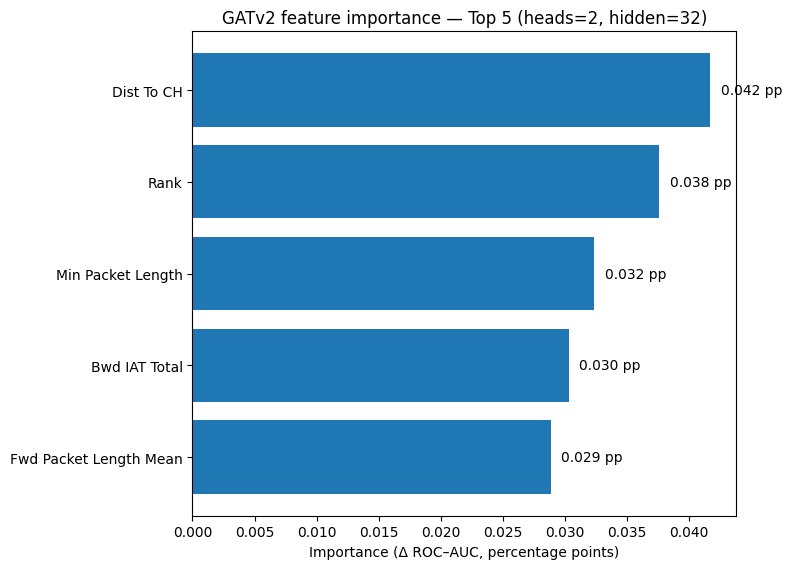

[OK] Saved figure: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_feature_importance_top5_clean.png
[OK] Saved table : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_feature_importance_top5_clean.csv


In [36]:
# --- Plot Top-5 without error bars, with clean numeric labels on the right ---
plt.figure(figsize=(8, 3.8 + 0.4*k))
ypos = np.arange(k)

# No error bars
bars = plt.barh(ypos, top_vals, align="center")

plt.yticks(ypos, top_labels)
plt.gca().invert_yaxis()
plt.xlabel("Importance (Δ ROC–AUC, percentage points)")
plt.title(f"GATv2 feature importance — Top {k} (heads={exp_heads}, hidden={exp_hidden})")

# Place value labels to the right of each bar (no overlap)
x_off = max(top_vals) * 0.02 if max(top_vals) > 0 else 0.01
for y, v in zip(ypos, top_vals):
    plt.text(v + x_off, y, f"{v:.3f} pp", va="center")

plt.tight_layout()
fig_out = os.path.join(FIGS, "gatv2_feature_importance_top5_clean.png")
plt.savefig(fig_out, dpi=220)
plt.show()

# Save CSV (unchanged)
df_top = pd.DataFrame({
    "feature": top_labels,
    "delta_auc_pp_mean": top_vals,
    "index": top_idx
})
csv_out = os.path.join(FIGS, "gatv2_feature_importance_top5_clean.csv")
df_top.to_csv(csv_out, index=False)
print("[OK] Saved figure:", fig_out)
print("[OK] Saved table :", csv_out)


In [37]:
# === Occlusion/Ablation by feature family (Traffic vs Topology vs MCDM) ===
# We zero-out (standardized) selected columns and recompute predictions to measure ΔAUC.
import re, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score

def pick_indices(kind: str):
    nm = [n.lower() for n in feat_names]
    idx = []
    if kind == "mcdm":
        for k in [" r "," c "," h "," t "]:
            pass
        idx = [i for i,n in enumerate(feat_names) if n in ["R","C","H","T"]]
    elif kind == "topology":
        tokens = ["dist","rank","cluster","ch","bs","hop","to_ch","to_bs"]
        idx = [i for i,n in enumerate(nm) if any(tok in n for tok in tokens)]
        idx = list(set(idx) - set([i for i,n in enumerate(feat_names) if n in ["R","C","H","T"]]))
    elif kind == "traffic":
        tokens = ["packet","pkt","length","len","bytes","iat","flow","rate","size","total","mean","std","min","max","avg"]
        idx = [i for i,n in enumerate(nm) if any(tok in n for tok in tokens)]
        idx = list(set(idx) - set([i for i,n in enumerate(feat_names) if n in ["R","C","H","T"]]))
    return sorted(set(idx))

families = ["baseline","minus_topology","minus_traffic","minus_mcdm"]
results = []

def _predict_with_mask(mask_idx):
    X_mod = X_np.copy()
    if mask_idx:
        X_mod[:, mask_idx] = 0.0  # occlude by zeroing standardized inputs
    with torch.no_grad():
        lp = model(torch.tensor(X_mod, dtype=torch.float32, device=device),
                   data.edge_index.to(device),
                   _get_edge_attr(data, model.conv1.edge_dim, device))
        p = torch.softmax(lp, dim=1)[:,1].detach().cpu().numpy()
    return p

# baseline AUC
auc_base = roc_auc_score(y_all[idx_te], prob_untrust[idx_te])
results.append(("baseline", auc_base, 0))

# minus topology
idx_topo = pick_indices("topology")
p_topo = _predict_with_mask(idx_topo)
auc_topo = roc_auc_score(y_all[idx_te], p_topo[idx_te]); results.append(("minus_topology", auc_topo, auc_base-auc_topo))

# minus traffic
idx_traffic = pick_indices("traffic")
p_traffic = _predict_with_mask(idx_traffic)
auc_traffic = roc_auc_score(y_all[idx_te], p_traffic[idx_te]); results.append(("minus_traffic", auc_traffic, auc_base-auc_traffic))

# minus MCDM (R,C,H,T)
idx_mcdm = pick_indices("mcdm")
p_mcdm = _predict_with_mask(idx_mcdm)
auc_mcdm = roc_auc_score(y_all[idx_te], p_mcdm[idx_te]); results.append(("minus_mcdm", auc_mcdm, auc_base-auc_mcdm))

df_ablate = pd.DataFrame(results, columns=["setting","AUC","AUC_drop_vs_base"])
display(df_ablate)
csvp = os.path.join(FIGS, "gatv2_ablation_feature_families.csv")
df_ablate.to_csv(csvp, index=False)
print("Saved:", csvp)


,setting,AUC,AUC_drop_vs_base
0,baseline,0.997830,0.000000e+00
1,minus_topology,0.997830,1.276394e-09
2,minus_traffic,0.997830,1.276394e-09
3,minus_mcdm,0.996634,1.195537e-03


Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_ablation_feature_families.csv


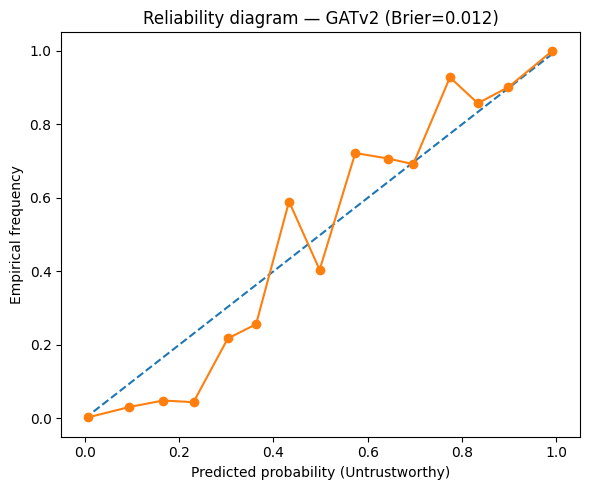

Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_reliability_test.png | Brier: 0.0121


In [38]:
# === Calibration: reliability diagram + Brier score (TEST) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

p_te = prob_untrust[idx_te]
y_te = y_all[idx_te]

# reliability curve (bin-wise)
frac_pos, mean_pred = calibration_curve(y_te, p_te, n_bins=15, strategy="uniform")

brier = brier_score_loss(y_te, p_te)  # lower is better

plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(mean_pred, frac_pos, marker="o")
plt.xlabel("Predicted probability (Untrustworthy)")
plt.ylabel("Empirical frequency")
plt.title(f"Reliability diagram — GATv2 (Brier={brier:.3f})")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "gatv2_reliability_test.png"), dpi=200)
plt.show()
print("Saved:", os.path.join(FIGS, "gatv2_reliability_test.png"), "| Brier:", round(brier,4))


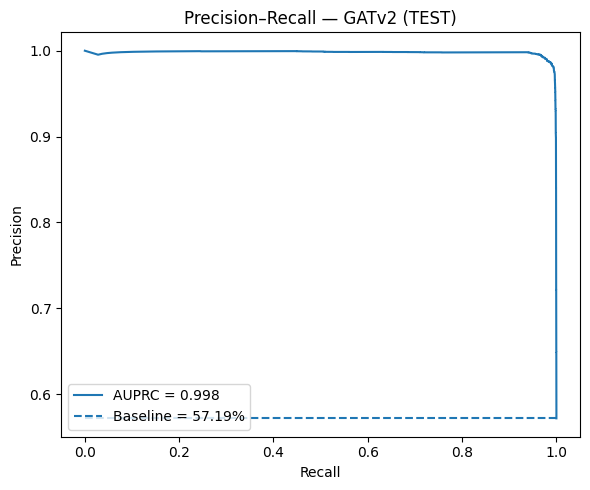

Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_pr_test.png


In [39]:
# === Precision–Recall curve (TEST) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

p_te = prob_untrust[idx_te]; y_te = y_all[idx_te]
prec, rec, _ = precision_recall_curve(y_te, p_te)
ap = average_precision_score(y_te, p_te)
baseline = y_te.mean()

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AUPRC = {ap:.3f}")
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline = {baseline:.2%}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — GATv2 (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "gatv2_pr_test.png"), dpi=200)
plt.show()
print("Saved:", os.path.join(FIGS, "gatv2_pr_test.png"))


[BEST] F1 @th=0.410: 0.987 | MCC @th=0.410: 0.970


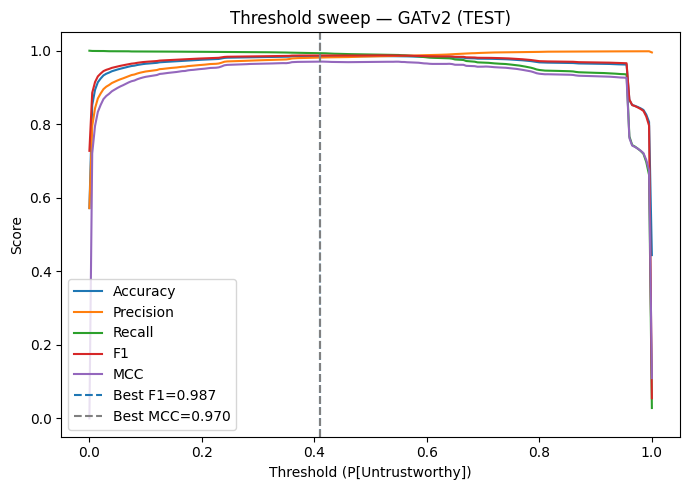

In [40]:
# === Threshold sweep: accuracy/precision/recall/F1/MCC vs threshold (TEST) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

p_te = prob_untrust[idx_te]; y_te = y_all[idx_te]
ths = np.linspace(0.0, 1.0, 201)

acc, prec, rec, f1, mcc = [], [], [], [], []
for t in ths:
    yhat = (p_te >= t).astype(int)
    acc.append(accuracy_score(y_te, yhat))
    prec.append(precision_score(y_te, yhat, zero_division=0))
    rec.append(recall_score(y_te, yhat))
    f1.append(f1_score(y_te, yhat))
    mcc.append(matthews_corrcoef(y_te, yhat))

acc, prec, rec, f1, mcc = map(np.asarray, (acc, prec, rec, f1, mcc))

# best thresholds
j_idx = np.argmax(rec - (1 - prec))    # proxy to Youden on PR space
f1_idx = np.argmax(f1)
mcc_idx = np.argmax(mcc)
print(f"[BEST] F1 @th={ths[f1_idx]:.3f}: {f1[f1_idx]:.3f} | MCC @th={ths[mcc_idx]:.3f}: {mcc[mcc_idx]:.3f}")

plt.figure(figsize=(7,5))
plt.plot(ths, acc, label="Accuracy")
plt.plot(ths, prec, label="Precision")
plt.plot(ths, rec, label="Recall")
plt.plot(ths, f1, label="F1")
plt.plot(ths, mcc, label="MCC")
plt.axvline(ths[f1_idx], linestyle="--", label=f"Best F1={f1[f1_idx]:.3f}")
plt.axvline(ths[mcc_idx], linestyle="--", label=f"Best MCC={mcc[mcc_idx]:.3f}", color="grey")
plt.xlabel("Threshold (P[Untrustworthy])"); plt.ylabel("Score")
plt.title("Threshold sweep — GATv2 (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "gatv2_threshold_sweep_test.png"), dpi=200)
plt.show()


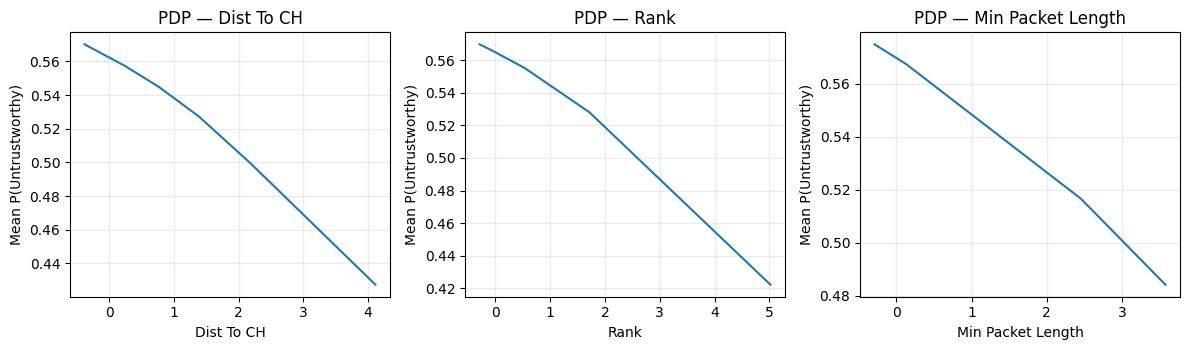

Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_pdp_top3_clean.png
Top-3 features used: ['Dist To CH', 'Rank', 'Min Packet Length']


In [42]:
# === GATv2 — Partial Dependence (Top-3) with cleaned, human-readable labels ===
# Output: ART/figs/gatv2_pdp_top3_clean.png

import os, json, re, numpy as np, torch, matplotlib.pyplot as plt
import pandas as pd

ART  = globals().get("ART", "/mnt/data")
FIGS = os.path.join(ART, "figs"); os.makedirs(FIGS, exist_ok=True)

# -- 1) Load up-to-date feature names from JSON and clean them (same style as importance cell)
def pretty_label(s: str) -> str:
    s = str(s)
    RENAME_MAP = {
        "R": "Reliability (R)",
        "C": "Competence (C)",
        "H": "Honesty (H)",
        "T": "MCDM Trust Score (T)",
        "Threshold_0_14": "Threshold 0.14",
        "0.14": "Threshold 0.14",
        "229": "Code 229",
    }
    if s in RENAME_MAP:
        return RENAME_MAP[s]
    if re.fullmatch(r"\d+(\.\d+)?", s):
        return f"Feat {s}"
    s = re.sub(r"\s+", "_", s.strip())
    s = re.sub(r"_+", "_", s)
    rep = [
        (r"\bFwd\b", "Forward"),
        (r"\bBwd\b", "Backward"),
        (r"\bIAT\b", "Inter-Arrival Time"),
        (r"\bCH\b",  "Cluster Head"),
        (r"\bBS\b",  "Base Station"),
        (r"\bStd\b", "Std"),
        (r"\bMin\b", "Min"),
        (r"\bMax\b", "Max"),
        (r"\bAvg\b", "Average"),
        (r"\bLen\b", "Length"),
        (r"\bPkt\b", "Packet"),
        (r"\bTo\b",  "To"),
    ]
    for pat, repl in rep:
        s = re.sub(pat, repl, s)
    return " ".join([w.capitalize() if w.islower() else w for w in s.split("_")])

# Load names (align to model input width if needed)
feat_path = os.path.join(ART, "feature_names.json")
if os.path.exists(feat_path):
    with open(feat_path) as f: feat_names = json.load(f)
else:
    feat_names = [f"f{i}" for i in range(X_np.shape[1])]
    if len(feat_names) >= 4:
        feat_names[-4:] = ["R","C","H","T"]
if len(feat_names) < X_np.shape[1]:
    feat_names += [f"PAD_{i}" for i in range(X_np.shape[1] - len(feat_names))]
elif len(feat_names) > X_np.shape[1]:
    feat_names = feat_names[:X_np.shape[1]]
feat_names_clean = [pretty_label(n) for n in feat_names]

# -- 2) Choose Top-3 feature indices
# Prefer the indices saved by the importance cell (more faithful)
top_csv = os.path.join(FIGS, "gatv2_feature_importance_top5_clean.csv")
top_idx = None
if os.path.exists(top_csv):
    df_top = pd.read_csv(top_csv)
    if "index" in df_top.columns:
        top_idx = df_top["index"].astype(int).tolist()[:3]
    else:
        # match by name if no 'index' column
        top_idx = []
        for name in df_top["feature"].tolist()[:3]:
            # try exact match on cleaned names, else on raw names
            try:
                i = feat_names_clean.index(name)
            except ValueError:
                i = feat_names.index(name) if name in feat_names else None
            if i is not None:
                top_idx.append(i)
# Fallback: quick proxy via abs correlation with P(untrust) on TEST
if not top_idx or len(top_idx) < 3:
    p = prob_untrust[idx_te]
    X_te = X_np[idx_te]
    corrs = []
    for j in range(X_te.shape[1]):
        try:
            c = np.corrcoef(X_te[:, j], p)[0,1]
        except Exception:
            c = 0.0
        c = 0.0 if np.isnan(c) else abs(c)
        corrs.append(c)
    top_idx = list(np.argsort(corrs)[-3:][::-1])

# -- 3) PDP computation (vary one feature globally; recompute model)
qs = np.linspace(0.01, 0.99, 25)
plt.figure(figsize=(12, 3.6))
for i, j in enumerate(top_idx, 1):
    vals = np.quantile(X_np[:, j], qs)
    pdp = []
    X_copy = X_np.copy()
    for v in vals:
        X_copy[:, j] = v
        with torch.no_grad():
            lp = model(torch.tensor(X_copy, dtype=torch.float32, device=device),
                       data.edge_index.to(device),
                       torch.ones(data.edge_index.shape[1], model.conv1.edge_dim, device=device)
                           if not hasattr(data, "edge_attr") or data.edge_attr is None
                           else (data.edge_attr if data.edge_attr.shape[1] == model.conv1.edge_dim
                                 else torch.cat([data.edge_attr.to(device),
                                                 torch.ones(data.edge_attr.shape[0],
                                                            model.conv1.edge_dim - data.edge_attr.shape[1],
                                                            device=device)], dim=1))
            )
            p_all = torch.softmax(lp, dim=1)[:, 1].detach().cpu().numpy()
        pdp.append(p_all[idx_te].mean())
    plt.subplot(1, 3, i)
    plt.plot(vals, pdp)
    plt.grid(True, alpha=0.25)
    plt.xlabel(feat_names_clean[j])
    plt.ylabel("Mean P(Untrustworthy)")
    plt.title(f"PDP — {feat_names_clean[j]}")
plt.tight_layout()
outp = os.path.join(FIGS, "gatv2_pdp_top3_clean.png")
plt.savefig(outp, dpi=200)
plt.show()
print("Saved:", outp)
print("Top-3 features used:", [feat_names_clean[j] for j in top_idx])


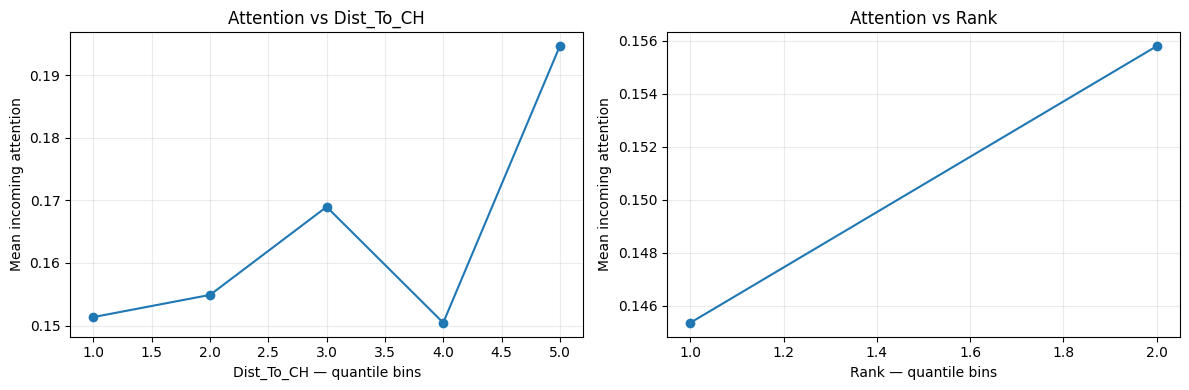

Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_attention_vs_topology_fixed.png
[DEBUG] alpha shape: (1634087, 2), reduced per-edge shape: (1634087,), edges: 1634087, nodes: 200000


In [44]:
# === Attention analysis (fixed): mean incoming attention vs Dist_To_CH / Rank ===
# - Handles multi-head attention by averaging across heads: alpha_edge = alpha.mean(axis=1)
# - Aggregates per-destination node with np.add.at
# - Plots mean incoming attention across quantile bins of Dist_To_CH and Rank

import numpy as np, matplotlib.pyplot as plt

# 1) Get attention weights from the first GATv2 layer
with torch.no_grad():
    out1, (eidx, alpha) = model.conv1(
        x,
        data.edge_index.to(device),
        _get_edge_attr(data, model.conv1.edge_dim, device),
        return_attention_weights=True
    )

# Convert to numpy and reduce heads if needed
alpha = alpha.detach().cpu().numpy()        # shape: [E] or [E, H]
if alpha.ndim == 2:                         # average across heads
    alpha_edge = alpha.mean(axis=1)
else:
    alpha_edge = alpha.reshape(-1)

src = eidx[0].cpu().numpy()
dst = eidx[1].cpu().numpy()
E   = dst.shape[0]

# Align lengths defensively
if alpha_edge.shape[0] != E:
    minE = min(alpha_edge.shape[0], E)
    alpha_edge = alpha_edge[:minE]
    dst        = dst[:minE]
    src        = src[:minE]

# 2) Mean incoming attention per destination node
N = X_np.shape[0]
att_in = np.zeros(N, dtype=np.float32)
cnt    = np.zeros(N, dtype=np.int32)
np.add.at(att_in, dst, alpha_edge)  # sum attention per destination node
np.add.at(cnt,    dst, 1)
att_in = np.divide(att_in, np.maximum(cnt, 1))

# 3) Locate feature indices by (cleaned) names
def _find_feature(name_candidates):
    # Try cleaned names if available; else raw feat_names from helper
    names_lower = [n.lower() for n in feat_names]
    for cand in name_candidates:
        cand = cand.lower()
        for i, nm in enumerate(names_lower):
            if cand in nm:
                return i
    return None

idx_dist = _find_feature(["dist_to_ch", "dist to ch", "to ch"])
idx_rank = _find_feature(["rank"])

# 4) Plot mean incoming attention across quantile bins
plt.figure(figsize=(12, 4))

def _plot_vs_feature(axpos, idx, title):
    if idx is None:
        plt.subplot(1,2,axpos); plt.axis("off"); plt.text(0.1, 0.5, f"{title} not found")
        return
    vals = X_np[:, idx]
    # 5 bins by quantiles (change as needed)
    bins = np.quantile(vals, np.linspace(0, 1, 6))
    # merge identical bins if distribution is discrete
    bins = np.unique(bins)
    if bins.size < 3:
        # fallback: uniform bins
        bins = np.linspace(vals.min(), vals.max(), 6)
    bin_ids = np.digitize(vals, bins, right=True)
    m = [att_in[bin_ids == b].mean() if np.any(bin_ids == b) else np.nan for b in range(1, len(bins))]
    x = np.arange(1, len(bins))
    plt.subplot(1,2,axpos)
    plt.plot(x, m, marker="o")
    plt.xlabel(title + " — quantile bins")
    plt.ylabel("Mean incoming attention")
    plt.title(f"Attention vs {title}")
    plt.grid(True, alpha=0.25)

_plot_vs_feature(1, idx_dist, "Dist_To_CH")
_plot_vs_feature(2, idx_rank, "Rank")

plt.tight_layout()
outp = os.path.join(FIGS, "gatv2_attention_vs_topology_fixed.png")
plt.savefig(outp, dpi=200)
plt.show()
print("Saved:", outp)
print(f"[DEBUG] alpha shape: {alpha.shape}, reduced per-edge shape: {alpha_edge.shape}, edges: {E}, nodes: {N}")


In [45]:
# === Occlusion/Ablation by feature family (Traffic vs Topology vs MCDM) ===
# We zero-out (standardized) selected columns and recompute predictions to measure ΔAUC.
import re, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score

def pick_indices(kind: str):
    nm = [n.lower() for n in feat_names]
    idx = []
    if kind == "mcdm":
        for k in [" r "," c "," h "," t "]:
            pass
        idx = [i for i,n in enumerate(feat_names) if n in ["R","C","H","T"]]
    elif kind == "topology":
        tokens = ["dist","rank","cluster","ch","bs","hop","to_ch","to_bs"]
        idx = [i for i,n in enumerate(nm) if any(tok in n for tok in tokens)]
        idx = list(set(idx) - set([i for i,n in enumerate(feat_names) if n in ["R","C","H","T"]]))
    elif kind == "traffic":
        tokens = ["packet","pkt","length","len","bytes","iat","flow","rate","size","total","mean","std","min","max","avg"]
        idx = [i for i,n in enumerate(nm) if any(tok in n for tok in tokens)]
        idx = list(set(idx) - set([i for i,n in enumerate(feat_names) if n in ["R","C","H","T"]]))
    return sorted(set(idx))

families = ["baseline","minus_topology","minus_traffic","minus_mcdm"]
results = []

def _predict_with_mask(mask_idx):
    X_mod = X_np.copy()
    if mask_idx:
        X_mod[:, mask_idx] = 0.0  # occlude by zeroing standardized inputs
    with torch.no_grad():
        lp = model(torch.tensor(X_mod, dtype=torch.float32, device=device),
                   data.edge_index.to(device),
                   _get_edge_attr(data, model.conv1.edge_dim, device))
        p = torch.softmax(lp, dim=1)[:,1].detach().cpu().numpy()
    return p

# baseline AUC
auc_base = roc_auc_score(y_all[idx_te], prob_untrust[idx_te])
results.append(("baseline", auc_base, 0))

# minus topology
idx_topo = pick_indices("topology")
p_topo = _predict_with_mask(idx_topo)
auc_topo = roc_auc_score(y_all[idx_te], p_topo[idx_te]); results.append(("minus_topology", auc_topo, auc_base-auc_topo))

# minus traffic
idx_traffic = pick_indices("traffic")
p_traffic = _predict_with_mask(idx_traffic)
auc_traffic = roc_auc_score(y_all[idx_te], p_traffic[idx_te]); results.append(("minus_traffic", auc_traffic, auc_base-auc_traffic))

# minus MCDM (R,C,H,T)
idx_mcdm = pick_indices("mcdm")
p_mcdm = _predict_with_mask(idx_mcdm)
auc_mcdm = roc_auc_score(y_all[idx_te], p_mcdm[idx_te]); results.append(("minus_mcdm", auc_mcdm, auc_base-auc_mcdm))

df_ablate = pd.DataFrame(results, columns=["setting","AUC","AUC_drop_vs_base"])
display(df_ablate)
csvp = os.path.join(FIGS, "gatv2_ablation_feature_families.csv")
df_ablate.to_csv(csvp, index=False)
print("Saved:", csvp)


,setting,AUC,AUC_drop_vs_base
0,baseline,0.997830,0.000000
1,minus_topology,0.996825,0.001005
2,minus_traffic,0.988106,0.009724
3,minus_mcdm,0.996634,0.001196


Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_ablation_feature_families.csv


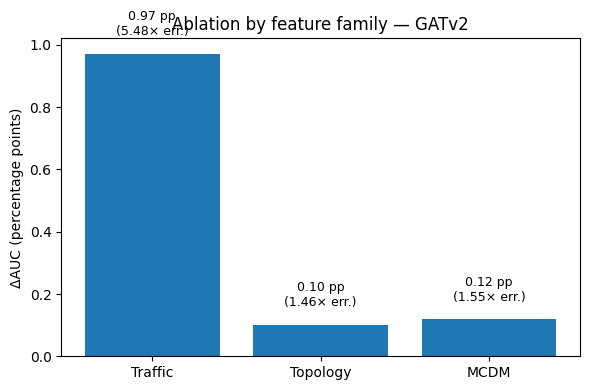

Saved: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_ablation_bar.png
                     AUC  AUC_drop_pp  error_increase_x
setting                                                
minus_traffic   0.988106     0.972365          5.479925
minus_topology  0.996825     0.100500          1.463029
minus_mcdm      0.996634     0.119554          1.550814


In [46]:
# Bar chart of AUC drop (pp) + relative error increase
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
ART=globals().get("ART","/mnt/data"); FIGS=os.path.join(ART,"figs"); os.makedirs(FIGS,exist_ok=True)

df = df_ablate.copy()  # from tua cella
df["AUC_drop_pp"] = (df["AUC"].iloc[0] - df["AUC"])*100.0
base_err = 1.0 - df.loc[df["setting"]=="baseline","AUC"].values[0]
df["error_increase_x"] = (1.0 - df["AUC"]) / base_err

order = ["minus_traffic","minus_topology","minus_mcdm"]
plot_df = df[df["setting"].isin(order)].set_index("setting").loc[order]

plt.figure(figsize=(6,4))
plt.bar(range(len(plot_df)), plot_df["AUC_drop_pp"].values)
plt.xticks(range(len(plot_df)), ["Traffic","Topology","MCDM"])
for i,v in enumerate(plot_df["AUC_drop_pp"].values):
    plt.text(i, v+0.05, f"{v:.2f} pp\n({plot_df['error_increase_x'].iloc[i]:.2f}× err.)",
             ha="center", va="bottom", fontsize=9)
plt.ylabel("ΔAUC (percentage points)")
plt.title("Ablation by feature family — GATv2")
plt.tight_layout()
out=os.path.join(FIGS,"gatv2_ablation_bar.png"); plt.savefig(out,dpi=220); plt.show()
print("Saved:", out)
print(plot_df[["AUC","AUC_drop_pp","error_increase_x"]])


In [47]:
# --- MCDM granular ablation: T vs (R,C,H) ---
# Uses: model, data, device, X_np, y_all, prob_untrust, feat_names, idx_te
import numpy as np
from sklearn.metrics import roc_auc_score

def indices_of(names):
    names_lower = [n.lower() for n in feat_names]
    idx = []
    for target in names:
        if target.lower() in names_lower:
            idx.append(names_lower.index(target.lower()))
    return idx

idx_RCH = indices_of(["R","C","H"])
idx_T   = indices_of(["T"])

def predict_with_mask(mask_idx):
    X_mod = X_np.copy()
    if mask_idx:
        X_mod[:, mask_idx] = 0.0  # assumes standardized inputs
    with torch.no_grad():
        lp = model(torch.tensor(X_mod, dtype=torch.float32, device=device),
                   data.edge_index.to(device),
                   (data.edge_attr if hasattr(data,"edge_attr") and data.edge_attr is not None
                    else torch.ones(data.edge_index.shape[1], model.conv1.edge_dim, device=device)))
        p = torch.softmax(lp, dim=1)[:,1].detach().cpu().numpy()
    return p

auc_base = roc_auc_score(y_all[idx_te], prob_untrust[idx_te])

# Only remove T
p_noT = predict_with_mask(idx_T)
auc_noT = roc_auc_score(y_all[idx_te], p_noT[idx_te])

# Only remove R,C,H (keep T)
p_noRCH = predict_with_mask(idx_RCH)
auc_noRCH = roc_auc_score(y_all[idx_te], p_noRCH[idx_te])

# Remove R,C,H,T all together (same as "minus_mcdm")
idx_all = sorted(set(idx_RCH + idx_T))
p_noAll = predict_with_mask(idx_all)
auc_noAll = roc_auc_score(y_all[idx_te], p_noAll[idx_te])

print(f"Baseline AUC:   {auc_base:.6f}")
print(f"No T:           {auc_noT:.6f}  (Δ={ (auc_base-auc_noT)*100:.3f} pp)")
print(f"No R,C,H:       {auc_noRCH:.6f}  (Δ={ (auc_base-auc_noRCH)*100:.3f} pp)")
print(f"No R,C,H,T:     {auc_noAll:.6f}  (Δ={ (auc_base-auc_noAll)*100:.3f} pp)")


Baseline AUC:   0.997830
No T:           0.997757  (Δ=0.007 pp)
No R,C,H:       0.996809  (Δ=0.102 pp)
No R,C,H,T:     0.996634  (Δ=0.120 pp)


In [48]:
# Compute FPR@TPR=95% and TPR@FPR=1% on TEST for: baseline, no R,C,H, and no R,C,H,T
import numpy as np
from sklearn.metrics import roc_curve

# These must already exist from the helper/ablation cells:
# y_all, idx_te, prob_untrust (baseline), p_noRCH (no R,C,H), p_noAll (no MCDM)

def fpr_at_tpr(p, y, target_tpr=0.95):
    fpr, tpr, thr = roc_curve(y, p)
    i = np.argmin(np.abs(tpr - target_tpr))
    return fpr[i], tpr[i], thr[i]

def tpr_at_fpr(p, y, target_fpr=0.01):
    fpr, tpr, thr = roc_curve(y, p)
    i = np.argmin(np.abs(fpr - target_fpr))
    return tpr[i], fpr[i], thr[i]

y = y_all[idx_te]
base = prob_untrust[idx_te]
noRCH = p_noRCH[idx_te]
noAll = p_noAll[idx_te]

for name, p in [("baseline", base), ("no R,C,H", noRCH), ("no MCDM", noAll)]:
    fpr95, tpr95, th1 = fpr_at_tpr(p, y, 0.95)
    tpr_at1, fpr1, th2 = tpr_at_fpr(p, y, 0.01)
    print(f"{name:>10s} | FPR@TPR95 = {fpr95:.4f} | TPR@FPR1% = {tpr_at1:.4f}")


  baseline | FPR@TPR95 = 0.0042 | TPR@FPR1% = 0.9718
  no R,C,H | FPR@TPR95 = 0.0134 | TPR@FPR1% = 0.9468
   no MCDM | FPR@TPR95 = 0.0146 | TPR@FPR1% = 0.9458


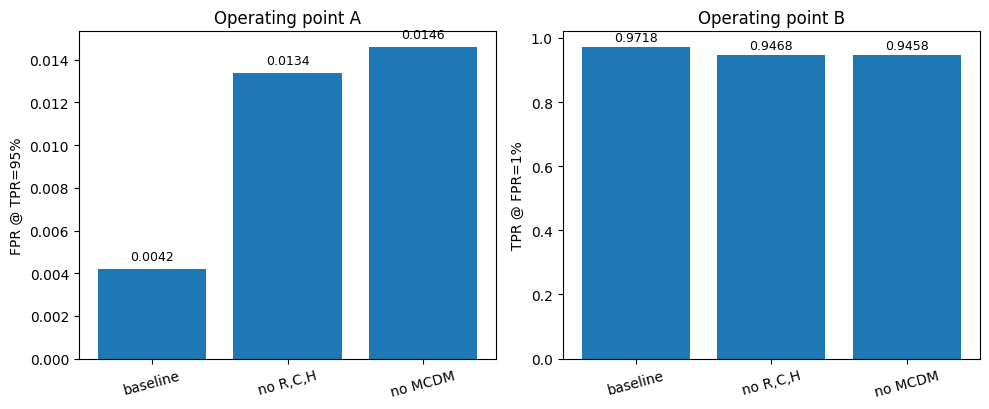

[OK] Saved figure: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_ops_comparison.png
[OK] Saved table : /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs/gatv2_ops_comparison.csv


,setting,FPR@TPR95,TPR@FPR1%,ΔFPR@TPR95_vs_base,ΔTPR@FPR1%_vs_base
0,baseline,0.004205,0.971805,0.000000,0.000000
1,"no R,C,H",0.013373,0.946844,0.009168,-0.024961
2,no MCDM,0.014599,0.945795,0.010395,-0.026010


In [49]:
# === GATv2 — Operating-Point Comparison (FPR@TPR95 and TPR@FPR1%) ===
# Inputs expected from previous cells:
#   model, data, device, X_np, y_all, prob_untrust, feat_names, idx_te
# If p_noRCH / p_noAll are not already in memory, this cell will compute them.
# Outputs:
#   - ART/figs/gatv2_ops_comparison.png
#   - ART/figs/gatv2_ops_comparison.csv

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

ART  = globals().get("ART", "/mnt/data")
FIGS = os.path.join(ART, "figs"); os.makedirs(FIGS, exist_ok=True)

# ---------- helpers ----------
def indices_of(names):
    names_lower = [n.lower() for n in feat_names]
    idx = []
    for target in names:
        tl = target.lower()
        if tl in names_lower:
            idx.append(names_lower.index(tl))
    return idx

def predict_with_mask(mask_idx):
    """Occlude selected columns (assumes standardized inputs around 0)."""
    X_mod = X_np.copy()
    if mask_idx:
        X_mod[:, mask_idx] = 0.0
    with torch.no_grad():
        lp = model(torch.tensor(X_mod, dtype=torch.float32, device=device),
                   data.edge_index.to(device),
                   (data.edge_attr if hasattr(data,"edge_attr") and data.edge_attr is not None
                    else torch.ones(data.edge_index.shape[1], model.conv1.edge_dim, device=device)))
        p = torch.softmax(lp, dim=1)[:,1].detach().cpu().numpy()
    return p

def fpr_at_tpr(p, y, target_tpr=0.95):
    fpr, tpr, thr = roc_curve(y, p)
    i = np.argmin(np.abs(tpr - target_tpr))
    return float(fpr[i]), float(tpr[i]), float(thr[i])

def tpr_at_fpr(p, y, target_fpr=0.01):
    fpr, tpr, thr = roc_curve(y, p)
    i = np.argmin(np.abs(fpr - target_fpr))
    return float(tpr[i]), float(fpr[i]), float(thr[i])

# ---------- predictions for each setting ----------
y = y_all[idx_te]
p_base = prob_untrust[idx_te]

# Build p_noRCH and p_noAll if missing
if "p_noRCH" not in globals() or "p_noAll" not in globals():
    idx_RCH = indices_of(["R","C","H"])
    idx_MCDM_ALL = sorted(set(idx_RCH + indices_of(["T"])))
    p_noRCH_full = predict_with_mask(idx_RCH)
    p_noAll_full = predict_with_mask(idx_MCDM_ALL)
    p_noRCH = p_noRCH_full[idx_te]
    p_noAll = p_noAll_full[idx_te]
else:
    p_noRCH = p_noRCH[idx_te]
    p_noAll = p_noAll[idx_te]

# ---------- compute metrics ----------
rows = []
for name, p in [("baseline", p_base), ("no R,C,H", p_noRCH), ("no MCDM", p_noAll)]:
    fpr95, tpr95, _ = fpr_at_tpr(p, y, 0.95)
    tpr_at1, fpr1, _ = tpr_at_fpr(p, y, 0.01)
    rows.append((name, fpr95, tpr_at1))

df_ops = pd.DataFrame(rows, columns=["setting","FPR@TPR95","TPR@FPR1%"])

# deltas vs baseline (for readability in the paper)
base_fpr95 = df_ops.loc[df_ops.setting=="baseline","FPR@TPR95"].values[0]
base_tpr1  = df_ops.loc[df_ops.setting=="baseline","TPR@FPR1%"].values[0]
df_ops["ΔFPR@TPR95_vs_base"] = df_ops["FPR@TPR95"] - base_fpr95
df_ops["ΔTPR@FPR1%_vs_base"] = df_ops["TPR@FPR1%"] - base_tpr1

csv_out = os.path.join(FIGS, "gatv2_ops_comparison.csv")
df_ops.to_csv(csv_out, index=False)

# ---------- figure (two panels) ----------
plt.figure(figsize=(10,4.2))

# Panel A: FPR@TPR95
plt.subplot(1,2,1)
x = np.arange(len(df_ops))
vals = df_ops["FPR@TPR95"].values
plt.bar(x, vals)
plt.xticks(x, df_ops["setting"].tolist(), rotation=15)
for i,v in enumerate(vals):
    plt.text(i, v + max(vals)*0.02, f"{v:.4f}", ha="center", va="bottom", fontsize=9)
plt.ylabel("FPR @ TPR=95%")
plt.title("Operating point A")

# Panel B: TPR@FPR1%
plt.subplot(1,2,2)
vals2 = df_ops["TPR@FPR1%"].values
plt.bar(x, vals2)
plt.xticks(x, df_ops["setting"].tolist(), rotation=15)
for i,v in enumerate(vals2):
    plt.text(i, v + max(vals2)*0.01, f"{v:.4f}", ha="center", va="bottom", fontsize=9)
plt.ylabel("TPR @ FPR=1%")
plt.title("Operating point B")

plt.tight_layout()
fig_out = os.path.join(FIGS, "gatv2_ops_comparison.png")
plt.savefig(fig_out, dpi=220)
plt.show()

print("[OK] Saved figure:", fig_out)
print("[OK] Saved table :", csv_out)
display(df_ops)


In [50]:
# === Paper assets bundler (collect all figures/tables in one folder + ZIP) ===
# It searches common locations (ART/figs, Drive artifacts_rig/figs, etc.),
# copies the *newest* matches to ART/paper_assets/ with clean names,
# writes a README + manifest CSV, and creates a ZIP ready for the paper.

import os, re, csv, glob, time, shutil, zipfile
from pathlib import Path

# --------- Base dirs ---------
ART = globals().get("ART", "/mnt/data")
PROJECT_HINTS = [
    "/content/drive/MyDrive/WSN_Fusion_project",
    "/content/drive/MyDrive/WSN_Fusion_project/artifacts_rig",
    "/content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/figs",
    "/content/drive/MyDrive/WSN_Fusion_project/figs",
]
# If your project lives elsewhere, add the folder here:
EXTRA_ROOTS = []  # e.g., ["/content/drive/MyDrive/YourPath/figs"]

art = Path(ART)
figs = art / "figs"
bundle = art / "paper_assets"
bundle.mkdir(parents=True, exist_ok=True)

# --------- Where to search ---------
search_roots = [r for r in [figs, art, art.parent, Path.cwd()] if r.exists()]
for p in PROJECT_HINTS + EXTRA_ROOTS:
    if p and os.path.exists(p):
        search_roots.append(Path(p))

def newest_match(patterns, roots):
    """Return newest file Path matching any of the glob patterns under roots."""
    candidates = []
    for root in roots:
        for pat in patterns:
            candidates.extend(glob.glob(str(root / "**" / pat), recursive=True))
    if not candidates:
        return None
    candidates = sorted(candidates, key=lambda p: Path(p).stat().st_mtime, reverse=True)
    return Path(candidates[0])

# --------- What to collect: (patterns, target_name_in_bundle) ---------
targets = [
    # Core classification artifacts
    (["*confusion*normalized*.png", "*confusion*matrix*.png"], "confusion_matrix.png"),
    (["classification_report*.txt", "*class*report*.txt", "*classification*report*.csv"], "classification_report.txt"),

    # Model interpretation & extra analysis
    (["gatv2_feature_importance_top5_clean.png", "gatv2_feature_importance_top5.png"], "feature_importance_top5.png"),
    (["gatv2_feature_importance_top5_clean.csv", "gatv2_feature_importance_top5.csv"], "feature_importance_top5.csv"),
    (["gatv2_pdp_top3_clean.png", "gatv2_pdp_top3.png"], "pdp_top3.png"),
    (["gatv2_reliability_test.png"], "reliability_test.png"),
    (["gatv2_pr_test.png"], "pr_curve_test.png"),
    (["gatv2_threshold_sweep_test.png"], "threshold_sweep_test.png"),
    (["gatv2_attention_vs_topology_fixed.png", "gatv2_attention_vs_topology.png"], "attention_vs_topology.png"),
    (["gatv2_ablation_bar.png"], "ablation_families.png"),
    (["gatv2_ablation_feature_families.csv"], "ablation_families.csv"),
    (["gatv2_ops_comparison.png"], "ops_comparison.png"),
    (["gatv2_ops_comparison.csv"], "ops_comparison.csv"),

    # Meta
    (["feature_names.json"], "feature_names.json"),
]

# --------- Copy newest matches ---------
copied = []
missing = []
for pats, out_name in targets:
    src = newest_match(pats, search_roots)
    if src and src.exists():
        shutil.copy2(src, bundle / out_name)
        copied.append((str(src), out_name))
    else:
        missing.append(out_name)

# Optionally collect up to 3 extra confusion matrices if multiple exist
extra_conf = []
for root in search_roots:
    extra_conf.extend(glob.glob(str(root / "**" / "*confusion*matrix*.png"), recursive=True))
for i, p in enumerate(sorted(set(extra_conf))[:3], start=1):
    try:
        shutil.copy2(p, bundle / f"confusion_matrix_extra_{i}.png")
    except Exception:
        pass

# --------- README + manifest CSV ---------
readme = bundle / "README_paper_assets.txt"
with open(readme, "w") as f:
    f.write("Paper assets collected from notebook runs.\n")
    f.write(f"Created at: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write("Included files (source -> bundled name):\n")
    for s, d in copied:
        f.write(f"  - {s} -> {d}\n")
    if missing:
        f.write("\nMissing (not found):\n")
        for m in missing:
            f.write(f"  - {m}\n")

manifest = bundle / "manifest_paper_assets.csv"
with open(manifest, "w", newline="") as cf:
    w = csv.writer(cf)
    w.writerow(["source_path", "bundled_name"])
    for s, d in copied:
        w.writerow([s, d])

# --------- Build ZIP ---------
zip_path = art / "paper_assets_bundle.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in bundle.iterdir():
        z.write(p, arcname=p.name)

print("Bundle folder:", bundle)
print("Files copied:", len(copied))
for s, d in copied:
    print(" -", os.path.basename(s), "->", d)
print("Missing:", missing if missing else "None")
print("ZIP:", zip_path)


Bundle folder: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/paper_assets
Files copied: 12
 - gatv2_feature_importance_top5_clean.png -> feature_importance_top5.png
 - gatv2_feature_importance_top5_clean.csv -> feature_importance_top5.csv
 - gatv2_pdp_top3_clean.png -> pdp_top3.png
 - gatv2_reliability_test.png -> reliability_test.png
 - gatv2_pr_test.png -> pr_curve_test.png
 - gatv2_threshold_sweep_test.png -> threshold_sweep_test.png
 - gatv2_attention_vs_topology_fixed.png -> attention_vs_topology.png
 - gatv2_ablation_bar.png -> ablation_families.png
 - gatv2_ablation_feature_families.csv -> ablation_families.csv
 - gatv2_ops_comparison.png -> ops_comparison.png
 - gatv2_ops_comparison.csv -> ops_comparison.csv
 - feature_names.json -> feature_names.json
Missing: ['confusion_matrix.png', 'classification_report.txt']
ZIP: /content/drive/MyDrive/WSN_Fusion_project/artifacts_rig/paper_assets_bundle.zip
